In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.colors as color
import matplotlib.pyplot as plt
import scipy
from scipy import stats
#Library for additional statistics and the descriptive function summary_cont() (more info than stats.describe()) 
import researchpy as rp
#Module to implement ANOVA tests
import statsmodels.api as sm
from statsmodels.formula.api import ols
#Module to implement post-hoc tests with Tukey's HSD method
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams["figure.figsize"] = (16, 7)
plt.style.use('ggplot')

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Overview of the data structure: 
Our main dataset [Dunnhumby - The complete journey](https://www.dunnhumby.com/careers/engineering/sourcefiles) comprises 8 csv files with the following tabular structure and content.

#### Products
Product Id | Manufacturer Id | Departement  | Brand | Commodity description | Sub commodity description | Size
--- | --- | --- | --- | --- | --- | --- 
 | | {grocery, pastry, etc.} | {national/private} | | |


#### Campaign Desc
> This table gives the length of time for which a campaign runs. So, any coupons received as part of a campaign are valid within the dates contained in this table.

Description | Campaign ID | Start and End Day
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int (probably day count from study)


#### Campaign Table
> This table lists the campaigns received by each household in the study. Each household received a different set of campaigns.

Description | Campaign ID | Household key
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int


#### Coupon Redemption
Household ID | Day | Coupon ID | Campaign ID 
--- | --- | --- | --- 
int | int | int | int 


#### Coupon
> This table lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable. Some coupons are redeemable for multiple products. 

Coupon ID | Product ID | Campaign ID 
--- | --- | ---  
int | int | int 


#### Casual Data
> This table signifies whether a given product was featured in the weekly mailer or was part of an in-store display (other than regular product placement).

Product ID | Store ID | Week | Display location | Mailer location
--- | --- | --- | --- | --- 
int | int | int | int | String
 | | | Advertisement in in-store display? | Featured as ad in weekly mailer


#### Demographic
> This table contains demographic information for a portion of households. Due to nature of the data, the demographic information is not available for all households.

Age | Marital Status Code | Income | Homeowner | Household composition | Household size | Number of kids | Household Id
--- | --- | --- | --- | --- | --- | --- | --- |
(19-65+) | {A: Married, B: Single, U: Unknown} | | {Homeowner, Retired, etc.} | {Female/Male single, adults with/without kids, etc.} || (1-3+) |
 
 
### Transaction
> This table contains all products purchased by households within this study. Each line found in this table is essentially the same line that would be found on a store receipt.

Household Id | Manufacturer Id | Week | Day | Time of Day | Product Id | Quantity | Sales value | Store Id | Retail discount | Coupon discount | Coupon match discount
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | | | | | | | What the shop actually gets | | | Loyalty program of retailer | Shop does not get price before discount | Shop does get price before discount

<div style="border:1px solid black; padding:30px 30px; background-color: #3388FF; text-align: center; font-size:30px;">
   <strong>Exploring the data</strong>
</div>

The goal of this first section is to explore and get a sense of the data. Let's start by loading it in pandas dataframes.

# Products
The first thing we want to do is design meaningful categories for the product we have in our database. This will allow us to study consumptions behaviours of the households.

In [5]:
df_products = pd.read_csv('dunnhumby/product.csv')
df_products.columns = map(str.lower, df_products.columns)
df_products.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


Let's explore the product data frame and filter out anything food related. We look at the columns *department*, *commodity_desc* and *sub_commodity_desc*.

In [6]:
def filter_dataframe(df, word_list):
    filtered_df = df.copy()
    for word in word_list:
        filtered_df = filtered_df[~(filtered_df["department"].str.contains(word) | filtered_df["commodity_desc"].str.contains(word) | filtered_df["sub_commodity_desc"].str.contains(word))]
    return df[~df.index.isin(filtered_df.index)], df[df.index.isin(filtered_df.index)]

In [7]:
meat_list = ["MEAT","PORK", "BEEF", "DUCK", "CHICKEN", "POULTRY", "LAMB", "VEAL",
             "MUTTON", "TURKEY", "VENISON", "WILD BOAR", "BISON", "GOOSE", "RABBIT", "PHEASANT"]
seafood_list = ["HERRING", "SEAFOOD", "SEAFD","SUSHI", "FISH","SHRIMP","SALMON","TUNA",
                "TILAPIA","ALASKA","POLLOCK","PANGASIUS","BASA","SWAI","COD","CATFISH","CRAB","CLAMS"]
sweets_snack_list = ["ROLLS", "GUM", "PASTRY", "NUT","CRACKERS","DESSERT","SNKS","SNACK","CHIP",
                     "CANDY", "ICE", "SWEET", "CHOCOLATE","POPCORN", "CAKE", "COOKIE", "PANCAKE",
                     "BAKING", "BAKE", "PIE"]
fruits_list = ["FRUIT","APPLE", "ORANGE", "PEAR", "BANANA", "GRAPE", "BERR", "TOMATO", "LEMON", "MELON", "PEACH", "CHERR", "PINEAPPLE", "CITRUS"]
vegetable_list = ["PUMPKIN", "COLESLAW", "SPINACH", "BEAN","VEG", "POTATO", "CARROT","CORN","PEPPER", "SQUASH", "ONION", "MUSHROOM", "CUCUMBER", "CAULIFLOWER", "BROCCOLI", "OLIVE" ]
veg_animal_list = ["DAIRY","MILK","CHEESE", "YOGURT", "BUTTER", "MARGARINE", "EGG", "HONEY"]
beverage_list = ["CIDER", "BEVERAGE", "WATER", "COKE", "FANTA", "SPRITE","LIQUOR", "LEMONADE", "COCOA", "VODKA", "BEER", "WINE", "COFFEE", "DRINK", "TEA", "JUICE", "DRNKS", "JCE"]
condiment_list = ["GARLIC","SALSA","FLOUR", "DIP","OIL","SEASONING","JELLY", "JAM","SAUCE", "HERBS", "CONDIMENT", "TOPPING", "SYRUP", "DRESSING", "KETCHUP", "MAYO", "DRSNG"]
carbs_list = ["NOODLES", "PASTA", "CROUTON","RICE", "BREAD", "TOAST", "CEREAL", "OATMEAL", "DOUGH", "POTATO"]
meal_list = ["PIZZA", "RAMEN", "SANDWICH", "SALAD","SOUP","ENTREE", "DINNER", "BREAKFAST", "THAI", "ASIAN", "ITALIAN", "MEXICAN", "GERMAN", "BURRITO", "FOOD", "ORIENTAL", "DISH", "KOSHER"]

df_meat, df_rest = filter_dataframe(df_products, meat_list)
df_seafood, df_rest = filter_dataframe(df_rest, seafood_list)
df_sweets_snack, df_rest = filter_dataframe(df_rest, sweets_snack_list)
df_fruits, df_rest = filter_dataframe(df_rest, fruits_list)
df_vegetable, df_rest = filter_dataframe(df_rest, vegetable_list)
df_veg_animal, df_rest = filter_dataframe(df_rest, veg_animal_list)
df_beverage, df_rest = filter_dataframe(df_rest, beverage_list)
df_condiments, df_rest = filter_dataframe(df_rest, condiment_list)
df_carbs, df_rest = filter_dataframe(df_rest, carbs_list)
df_meals, df_rest = filter_dataframe(df_rest, meal_list)

We also group some categories in Vegetarian and Non-vegetarian (note we have left out categories such as Meals or Condiments as one would need to have the precise list of ingredients to know if a spefific product is vegetarian or not).

In [8]:
df_veg = df_fruits.append(df_vegetable).append(df_veg_animal).append(df_carbs)
df_non_veg = df_meat.append(df_seafood)

In [9]:
df_food = pd.concat([df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals])
df_food.reset_index(drop=True)

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,27860,69,GROCERY,Private,BAKING NEEDS,PIE FILLING MINCEMEAT GLAZES,21 OZ
1,27951,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
2,28267,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
3,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
4,31493,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,10 OZ
...,...,...,...,...,...,...,...
58742,18037791,69,GROCERY,Private,DOG FOODS,DRY DOG ECONOMY (COST CUTTER/F,15 LBS
58743,18105562,6235,GROCERY,National,DOG FOODS,SEMI MOIST DOG FOOD,1.5 LB
58744,18107080,6235,GROCERY,National,DOG FOODS,SEMI MOIST DOG FOOD,1 LB
58745,18118989,69,GROCERY,Private,DOG FOODS,DRY DOG ECONOMY (COST CUTTER/F,37.5 LBS


In [10]:
nfoods_no_size = df_food[df_food["curr_size_of_product"] == " "].count()["product_id"]
nfoods = df_food.count()["product_id"]

In [11]:
print("We have sizes informations for {:.2f}% of food products".format(100 * (1 - nfoods_no_size / nfoods)))

We have sizes informations for 85.41% of food products


In [12]:
# Create df with all remaining products (even non-food products)
df_left_all = df_products[
    ~df_products.index.isin(
        np.concatenate(
            (
                df_meat.index,
                df_seafood.index,
                df_sweets_snack.index,
                df_fruits.index,
                df_vegetable.index,
                df_beverage.index,
                df_veg_animal.index,
                df_condiments.index,
                df_carbs.index,
                df_meals.index,
            )
        )
    )
]

We define a list of the categories and of the dataframes to easily access them later on.

In [13]:
#Categories of food 
categories = ['Meat', 'Seafood', 'Sweet snacks', 'Fruits', 'Vegetables', 'Veg animal', 'Beverage', 'Condiments', 'Carbs', 'Meals', 'Other']
df_list = (df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, 
           df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals, df_left_all)

Let's see the distribution of products we have in the dataset across these categories.

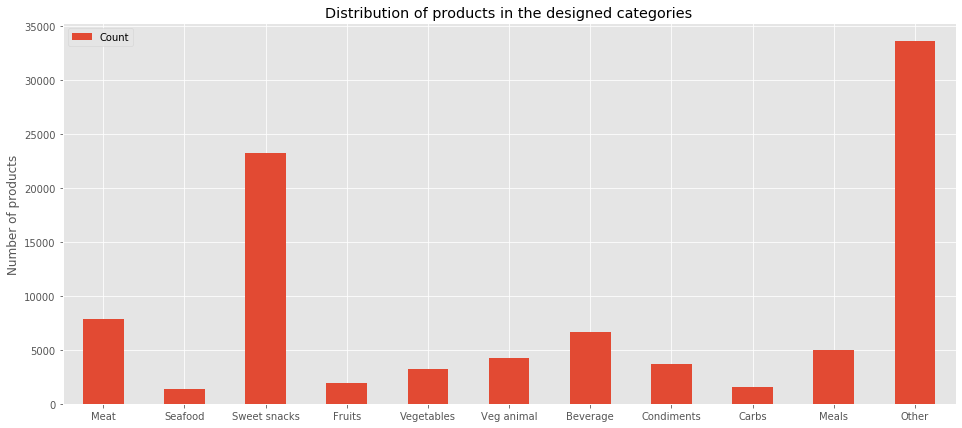

In [14]:
products_count = pd.DataFrame(columns = ['Category', 'Count'])
for categ,df in enumerate(df_list):
    products_count = products_count.append({'Category':categories[categ],
                                            'Count':len(df)}, ignore_index=True)
products_count.plot.bar()
plt.xticks(np.arange(11), categories, rotation = 'horizontal')
plt.ylabel('Number of products')
plt.title('Distribution of products in the designed categories')
plt.show()

# Campaigns & coupons

One of the important aspects of this dataset is the list of promoting campaigns conducted among the households, with informations on the related coupons. Let's explore the 4 dataframes related to these (2 specifically about the campaigns and 2 specifically about the coupons).

## Campaigns

In [15]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')
df_campaign_desc.columns = map(str.lower, df_campaign_desc.columns)
df_campaign_desc.head()

,description,campaign,start_day,end_day
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [16]:
print('Total number of campaigns: {} '.format(len(df_campaign_desc.campaign)))
print('Unique description values: {} '.format(df_campaign_desc.description.unique()))

Total number of campaigns: 30 
Unique description values: ['TypeB' 'TypeC' 'TypeA'] 


In [17]:
# Add duration column to dataframe
df_campaign_desc['duration'] = df_campaign_desc['end_day'] - df_campaign_desc['start_day'] 
df_campaign_desc.sort_values(by = 'duration', ascending = False).reset_index(drop=True).head(5)

,description,campaign,start_day,end_day,duration
0,TypeC,15,547,708,161
1,TypeC,20,615,685,70
2,TypeC,14,531,596,65
3,TypeC,27,237,300,63
4,TypeB,28,259,320,61


We can see that the longest campaign was on for 161 days, but this seems to be an outlier as the others don't last for more than 60-70 days.

In [18]:
for camp in ['TypeA', 'TypeB', 'TypeC']:
    print('Campaigns of %s range between %d and %d days' %(camp, df_campaign_desc[df_campaign_desc.description == camp].duration.min(),
                                                     df_campaign_desc[df_campaign_desc.description == camp].duration.max()))
    print('with a mean duration of %.2f days and a median duration of %.2f days. \n' 
            %(df_campaign_desc[df_campaign_desc.description == camp].duration.mean(),
              df_campaign_desc[df_campaign_desc.description == camp].duration.median()))

Campaigns of TypeA range between 40 and 55 days
with a mean duration of 47.20 days and a median duration of 47.00 days. 

Campaigns of TypeB range between 32 and 61 days
with a mean duration of 37.63 days and a median duration of 32.00 days. 

Campaigns of TypeC range between 32 and 161 days
with a mean duration of 74.50 days and a median duration of 64.00 days. 



We now look at the campaign table, containing the campaigns that each household has benefited from.

In [19]:
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')
df_campaign_table.columns = map(str.lower, df_campaign_table.columns)
df_campaign_table.head()

,description,household_key,campaign
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Since both campaign tables (one containing the data and the other providing further descriptions regarding each campaign) have one "key" in common, namely the `campaign id` we can join (full outer join) these two tables in order to have all information in one place.

In [20]:
df_campaign_full = pd.merge(df_campaign_desc, df_campaign_table, on='campaign', how='outer').rename(columns={"descritpion_x": "description"}).drop(columns='description_y')
# Map the lowering function to all column names
df_campaign_full.columns = map(str.lower, df_campaign_full.columns)
df_campaign_full.head(10)

,description_x,campaign,start_day,end_day,duration,household_key
0,TypeB,24,659,719,60,31
1,TypeB,24,659,719,60,149
2,TypeB,24,659,719,60,332
3,TypeB,24,659,719,60,371
4,TypeB,24,659,719,60,518
5,TypeB,24,659,719,60,553
6,TypeB,24,659,719,60,766
7,TypeB,24,659,719,60,706
8,TypeB,24,659,719,60,690
9,TypeB,24,659,719,60,676


#### Distributional analysis of how campaigns reached each household
Let's observe how the campaigns have reached the households. 

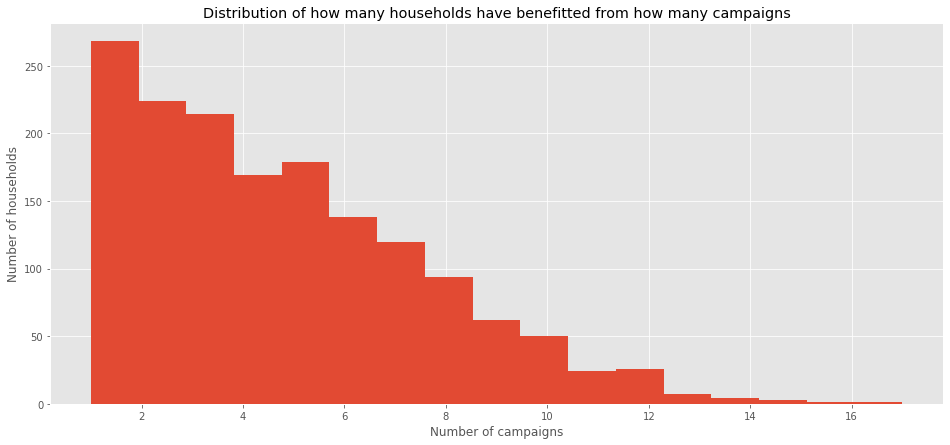

In [21]:
nbins = df_campaign_table.groupby(by = 'household_key').campaign.count().max()
df_campaign_table.groupby(by = 'household_key').campaign.count().hist(bins = nbins)
plt.title('Distribution of how many households have benefitted from how many campaigns')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.savefig("test.svg")

In the above plot we can see, that most households have only benefited from 1 campaign and very few have made use of more than 10 campaigns.

In [22]:
df_campaign_full.groupby(by = 'household_key').campaign.count().describe()

count    1584.000000
mean        4.550505
std         2.993988
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        17.000000
Name: campaign, dtype: float64

_Mean number of campaigns:_ ~4.55

_Max number of campaigns:_ 17

_Looking at the quantiles:_

* 25% of the households have made use of 2 campaigns or less. 
* 75% of the households have made use of 6 campaigns or less.
* 95% of the households have made use of 10 campaigns or less.

#### Timespan of the campaigns

Let's see the different campaigns over time.

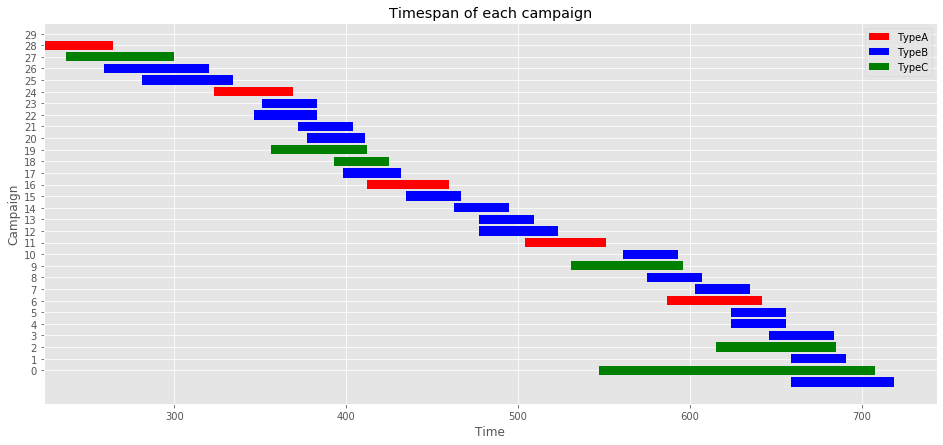

In [23]:
#Split the datas per campaign type for better visualization
beginA = df_campaign_desc[df_campaign_desc.description == 'TypeA']['start_day'].values
endA =   df_campaign_desc[df_campaign_desc.description == 'TypeA']['end_day'].values
beginB = df_campaign_desc[df_campaign_desc.description == 'TypeB']['start_day'].values
endB =   df_campaign_desc[df_campaign_desc.description == 'TypeB']['end_day'].values
beginC = df_campaign_desc[df_campaign_desc.description == 'TypeC']['start_day'].values
endC =   df_campaign_desc[df_campaign_desc.description == 'TypeC']['end_day'].values

#Plot the timespan of each campaign
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeA'].index.values,  endA-beginA, left=beginA, 
         color = 'red', label = 'TypeA')
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeB'].index.values,  endB-beginB, left=beginB, 
         color = 'blue', label = 'TypeB')
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeC'].index.values,  endC-beginC, left=beginC, 
         color = 'green', label = 'TypeC')

#Add title & legend
plt.title('Timespan of each campaign')
plt.ylabel('Campaign')
plt.yticks(np.arange(30)+1, df_campaign_desc.index)
plt.xlabel('Time')
plt.legend()
plt.show()

## Coupons

Let's start by loading and having a look at the two dataframes related to coupons.

In [24]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')
df_coupon_redempt.columns = map(str.lower, df_coupon_redempt.columns)
df_coupon_redempt.head()

,household_key,day,coupon_upc,campaign
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


In [25]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')
df_coupon.columns = map(str.lower, df_coupon.columns)
df_coupon.head()

,coupon_upc,product_id,campaign
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's study how many coupons were redeemed for each campaign:
we start by adding a column stating if a coupon has been redeemed or not. `coupon_upc` here is the unique identifier of each coupon.

In [26]:
df_coupon['redeemed'] = df_coupon['coupon_upc'].isin(df_coupon_redempt['coupon_upc'])
df_coupon.head()

,coupon_upc,product_id,campaign,redeemed
0,10000089061,27160,4,False
1,10000089064,27754,9,True
2,10000089073,28897,12,True
3,51800009050,28919,28,True
4,52100000076,28929,25,True


Let's observe how many coupons were distributed and redeemed by households.

In [27]:
num_redempt_coupons = df_coupon.redeemed[df_coupon.redeemed == True].shape[0]
redemption_rate = num_redempt_coupons / df_coupon.shape[0] * 100
print("{} of {} coupons in total were actually redeemed, which corresponds to a redemption rate of {} %.".format(num_redempt_coupons,df_coupon.shape[0], round(redemption_rate,2)))

108257 of 124548 coupons in total were actually redeemed, which corresponds to a redemption rate of 86.92 %.


The above rate is suprisingly high...

So let us have a look how many coupons were distributed within the course of each campaign, by combining the informations.

## Amount of coupons per campaign

Let's start by combining the campaigns data with the coupons data.

In [28]:
df_campaign_desc.sort_values(by = 'campaign', inplace = True)
df_campaign_desc.set_index(keys = 'campaign', drop = True, inplace = True)
df_campaign_desc['distributed'] = df_coupon.groupby(by = 'campaign').redeemed.count() #Number of coupons distributed
df_campaign_desc['redeemed'] = df_coupon[~df_coupon['redeemed']].groupby(by = 'campaign').redeemed.count() #Number of coupons redeemed
df_campaign_desc.fillna(0, inplace = True) 
df_campaign_desc['beneficiary'] = df_campaign_table.groupby(by = 'campaign').description.count() #Number of beneficiary households
df_campaign_desc.head()

,description,start_day,end_day,duration,distributed,redeemed,beneficiary
campaign,,,,,,,
1,TypeB,346,383,37,383,363.0,13
2,TypeB,351,383,32,301,78.0,48
3,TypeC,356,412,56,740,392.0,12
4,TypeB,372,404,32,200,84.0,81
5,TypeB,377,411,34,443,97.0,166


Let's observe these results in a bar plot. For each campaign we plot the amount of coupon distributed and redeemed, and we add the type of the campaign.

In [29]:
#coupon_distributed = df_campaign_desc['distributed']
df_campaign_desc.to_pickle("df_campaign_desc.pickle")

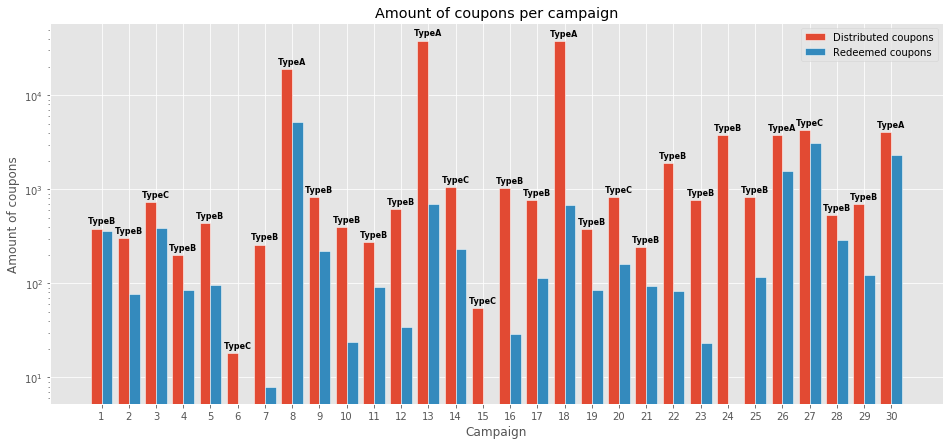

In [30]:
# set width of bar
barWidth = 0.4
 
# set height of bar
coupon_distributed = df_campaign_desc['distributed']
coupon_redeemed = df_campaign_desc['redeemed']
 
# Set position of bar on X axis
r = np.arange(len(coupon_distributed)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, coupon_distributed, width=barWidth, edgecolor='white', label='Distributed coupons')
plt.bar(r2, coupon_redeemed, width=barWidth, edgecolor='white', label='Redeemed coupons')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.description.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], coupon_distributed.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amount of coupons per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of coupons')
plt.legend()
plt.show()

Notice the y-axis is in logarithmic scale: this is done because the amounts of coupons differ a lot from one campaign to another. Moreover, we can see the difference between the amount of coupon distributed and redeemed differs a lot from one campaign to another. It goes from cases where it is nearly null (such as campaign 1) to extreme cases where no coupons were redeemed (such as in campaigns 6, 15 and 24). To understand what happened here, we will need to inspect more precisely each campaign and join our results with data about the products and the transactions.

# Advertisement analysis

In the dataset, informations about the displayement of the products in the stores and of the ads in the mailer are prodided. Let's have a look at these, grouping the products by categories of food.

In [31]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')
df_causal.columns = map(str.lower, df_causal.columns)
df_causal.head()

,product_id,store_id,week_no,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's start by changing the 'display' and 'mailer' values to make them more explicit. We will define two dict and then use the *map()* method for this.

In [32]:
display_dict = {'0':'Not on Display', '1':'Store Front', '2':'Store Rear', '3':'Front End Cap',
                '4':'Mid-Aisle End Cap', '5':'Read End Cap', '6':'Side-Aisle End Cap', '7':'In-Aisle' ,
                '9':'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {'0':'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

In [33]:
df_causal.display = df_causal.display.apply(lambda x: str(x))
df_causal.display = df_causal.display.map(display_dict, na_action = 'ignore')
df_causal.mailer = df_causal.mailer.map(mailer_dict, na_action = 'ignore')

Let's observe how many products we have in each category, both for display and mailer.

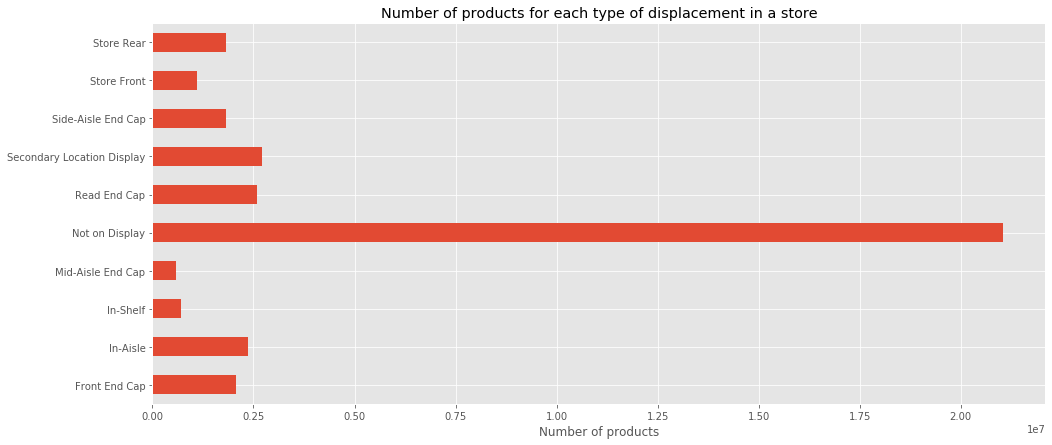

In [34]:
df_causal.groupby(by = 'display').count().mailer.plot(kind = 'barh')
plt.xlabel('Number of products')
plt.ylabel('')
plt.title('Number of products for each type of displacement in a store')
plt.show()

As expected, many products are simply not in display.

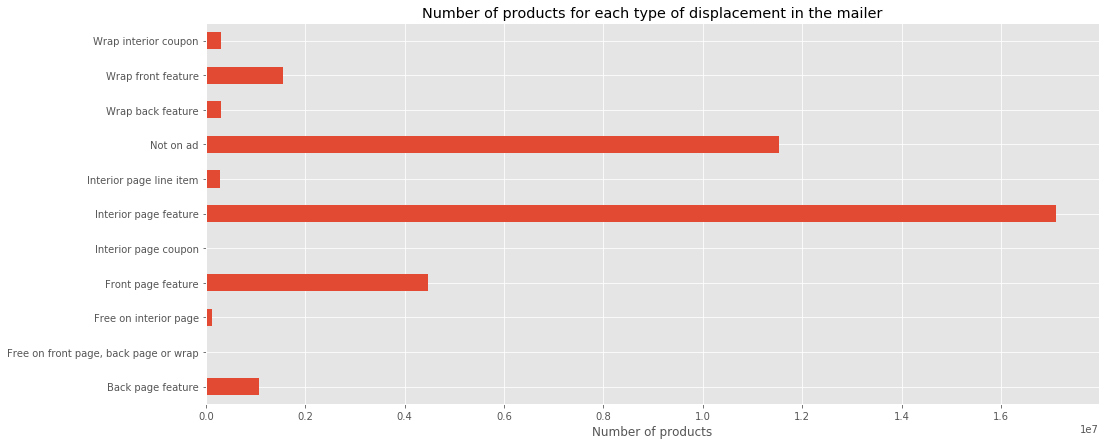

In [35]:
df_causal.groupby(by = 'mailer').count().display.plot(kind = 'barh')
plt.xlabel('Number of products')
plt.ylabel('')
plt.title('Number of products for each type of displacement in the mailer')
plt.show()

As expected, the largest numbers of ads are in the interior or front pages (or simply not on ad).

Let's now analyse the ads distribution for each category of food previously defined. To do this, we will define a function ads_categories() that will take a dataframe (one of the 11 dataframes of the categories of food) and return the distribution of ads (as percentages). A show_plot parameter will decide if we want to directly plot the distribution in a bar plot. We return both the raw count and the proportion.

In [36]:
def ads_categories(df, categ = '', show_plot = False):
    count = df.merge(df_causal, on = 'product_id').groupby(by = 'mailer').display.count()
    proportions = count.map(lambda x: 100*x/count.sum())
    
    if show_plot:
        proportions.plot.bar()
        plt.title('Proportion of mailer ads for %s' %categ)
        plt.xlabel('Type of ads')
        plt.xticks(rotation = 30)
        plt.ylabel('Proportion of ads [%]')
        plt.show()
    
    return (proportions,count)

Let's give an example for meat for instance.

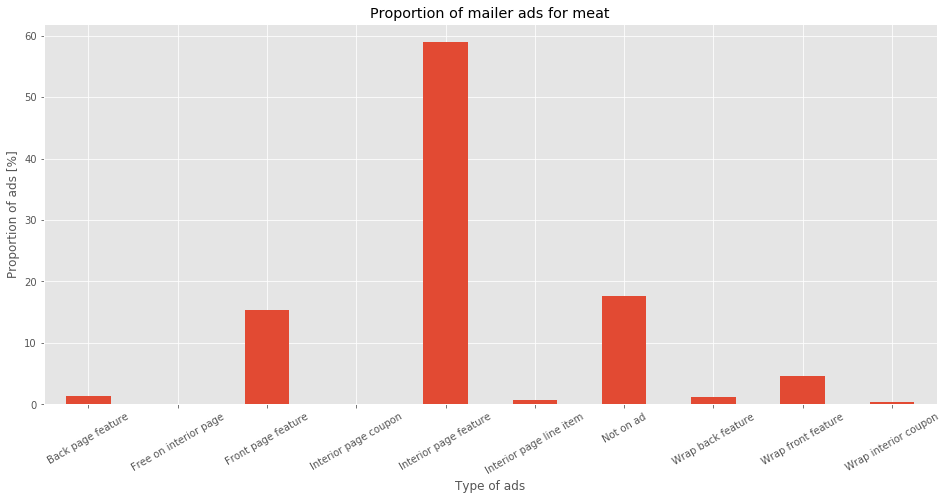

In [37]:
(prop_meat,count_meat) = ads_categories(df_meat, 'meat', True)

Let's create a dataframe to store the ads proportions for each category of food.

In [38]:
df_ads_prop = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_prop.sort_index(inplace = True)
df_ads_prop.index.name = 'Type of ads'

df_ads_count = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_count.sort_index(inplace = True)
df_ads_count.index.name = 'Type of ads'

In [39]:
for i,df in enumerate(df_list):
    df_ads_prop[categories[i]] = ads_categories(df)[0]
    df_ads_count[categories[i]] = ads_categories(df)[1]
df_ads_prop

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.326539,0.409529,2.898073,42.638624,10.425027,0.259567,0.529633,0.868442,0.263158,6.433533,0.635639
"Free on front page, back page or wrap",NaN,NaN,0.148451,NaN,NaN,0.029404,NaN,0.000306,NaN,0.024577,0.001866
Free on interior page,0.137972,NaN,0.431924,NaN,NaN,0.215896,0.922489,0.232625,0.516948,0.078540,0.211327
Front page feature,15.291547,0.902767,9.680359,7.371521,9.686958,31.973922,21.871803,1.482297,10.532672,10.895891,1.138383
Interior page coupon,0.000439,0.019757,0.000133,0.000149,NaN,NaN,NaN,0.000077,NaN,0.001020,0.007387
Interior page feature,58.947636,51.109178,40.776344,22.743902,50.829157,46.992706,27.394318,50.844376,59.244924,53.490345,55.223489
Interior page line item,0.644314,1.183181,1.080173,1.064265,0.395106,0.868441,0.116542,1.049721,0.750130,0.499800,0.801908
Not on ad,17.596684,37.669410,39.163240,19.163329,18.270194,13.624105,43.829632,40.113466,21.384956,20.376264,38.518944
Wrap back feature,1.159260,0.397571,1.222001,0.968626,0.403883,0.246589,0.560094,1.220976,0.078185,0.692629,0.305043


We notice some values are set to NaN. This happens because, if there are no ads of the specific type of mailer, it is simply missing from the series. We can therefore simply fill all NaN values with 0.

In [40]:
df_ads_prop.fillna(0, inplace = True)
df_ads_count.fillna(0, inplace = True)
df_ads_prop.head()

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.326539,0.409529,2.898073,42.638624,10.425027,0.259567,0.529633,0.868442,0.263158,6.433533,0.635639
"Free on front page, back page or wrap",0.000000,0.000000,0.148451,0.000000,0.000000,0.029404,0.000000,0.000306,0.000000,0.024577,0.001866
Free on interior page,0.137972,0.000000,0.431924,0.000000,0.000000,0.215896,0.922489,0.232625,0.516948,0.078540,0.211327
Front page feature,15.291547,0.902767,9.680359,7.371521,9.686958,31.973922,21.871803,1.482297,10.532672,10.895891,1.138383
Interior page coupon,0.000439,0.019757,0.000133,0.000149,0.000000,0.000000,0.000000,0.000077,0.000000,0.001020,0.007387


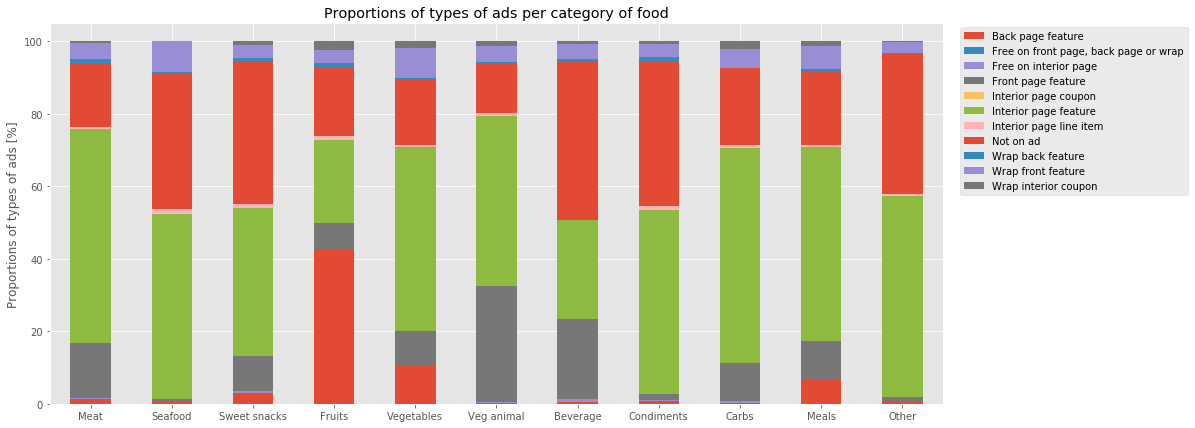

In [41]:
df_ads_prop.transpose().plot.bar(stacked = True) #The transpose() is needed to get the right kind of stacked barplot
plt.title('Proportions of types of ads per category of food')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of types of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.28,0.77))
plt.show()

Let's look more precisely at Not on ad, Front page feature, Interior page feature and Back page feature.

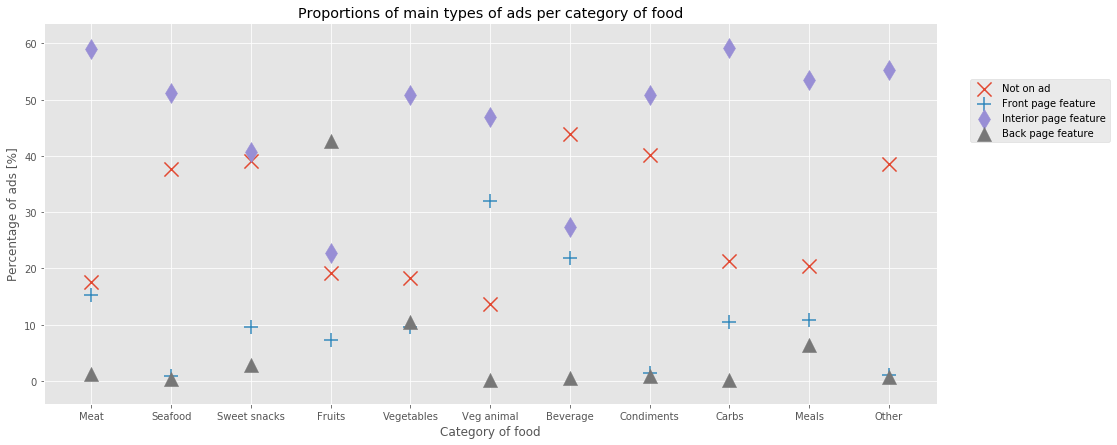

In [42]:
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Not on ad'], 
            label = 'Not on ad', marker = 'x', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Front page feature'], 
            label = 'Front page feature', marker = '+', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Interior page feature'], 
            label = 'Interior page feature', marker = 'd', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Back page feature'], 
            label = 'Back page feature', marker = '^', s = 200)
plt.xticks(range(len(categories)), list(categories))
plt.title('Proportions of main types of ads per category of food')
plt.xlabel('Category of food')
plt.ylabel('Percentage of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.2,0.77))
plt.show()

We can see that meat ads are mainly situated in the interior pages with very few in the back pages. On the contrary, fruits have much more ads in the back pages.

# Demographics

For some households, we have additional informations (such as the age, the income and the marital status).

In [43]:
marital_dict = {"A": "Married", "B": "Single", "U": "Unknown"}
household_size_dict = {"1": 1, "2": 2, "3": 3, "4": 4, "5+": 5}

In [44]:
df_demo = pd.read_csv("dunnhumby/hh_demographic.csv")
df_demo.columns = map(str.lower, df_demo.columns)

# Replace cryptic character with actual label
df_demo["married"] = df_demo["marital_status_code"].apply(
    lambda code: marital_dict[code]
)

# Create new column with numerical household size
for hh_str, hh_int in household_size_dict.items():
    df_demo["household_size_desc_numeric"] = df_demo["household_size_desc"].replace(
        hh_str, hh_int
    )
df_demo["household_size_desc_numeric"] = df_demo["household_size_desc_numeric"].astype(int)
    
df_demo.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,Married,2
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,Married,2
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,Unknown,3
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,Unknown,4
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,Single,1


Let's see for how many households we have these informations.

In [45]:
print('We have demographics informations for %d households.' %len(df_demo))

We have demographics informations for 801 households.


In our analysis we will focus on people grouped according to three criteria: marital status, income and age. Let's observe the distributions of those groups.

## Income

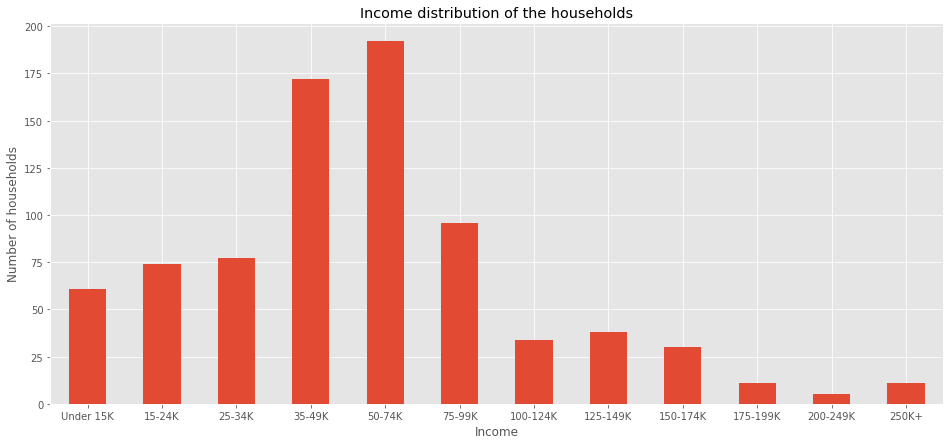

In [46]:
salary_index = [
    "Under 15K",
    "15-24K",
    "25-34K",
    "35-49K",
    "50-74K",
    "75-99K",
    "100-124K",
    "125-149K",
    "150-174K",
    "175-199K",
    "200-249K",
    "250K+",
]

df_demo["income_desc"].value_counts().sort_index().reindex(salary_index).plot(kind="bar")
plt.xlabel('Income')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Number of households')
plt.title('Income distribution of the households')
plt.show()

In [47]:
df_demo

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,Married,2
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,Married,2
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,Unknown,3
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,Unknown,4
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,Single,1
...,...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,Unknown,2
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,Married,3
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,Unknown,1
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,Unknown,2


## Age

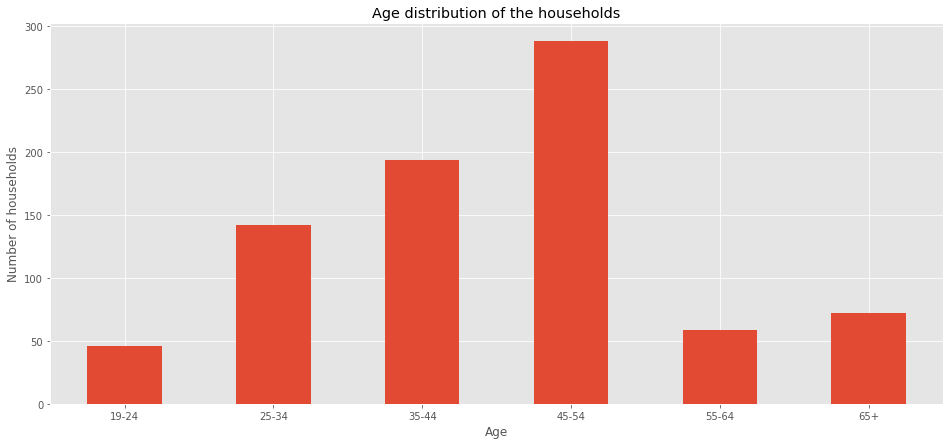

In [48]:
df_demo["age_desc"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('Age')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Number of households')
plt.title('Age distribution of the households')
plt.show()

## Marital status

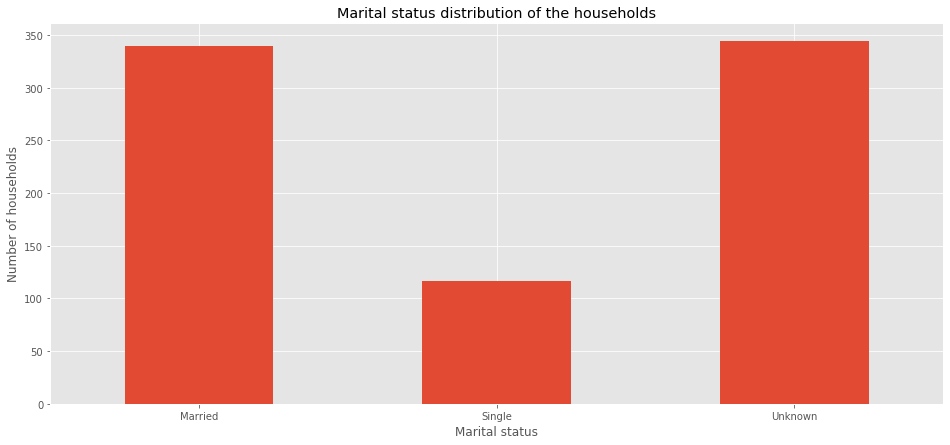

In [49]:
df_demo["married"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('Marital status')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Number of households')
plt.title('Marital status distribution of the households')
plt.show()

Since we have a lot of Unknown in the dataset, we will try to define new groups about the 'type' of family, using the *hh_comp_desc* informations. We define 4 categories: Adults No Kids, With kids (meaning one or more adults, with kids), Single and Unknown.

In [50]:
hh_comp = {'2 Adults No Kids':'Adults No Kids', 
           '1 Adult Kids':'With kids',
           '2 Adults Kids':'With kids', 
           'Single Female':'Single',
           'Single Male':'Single',
           'Unknown':'Unknown'}
df_demo.hh_comp_desc = df_demo.hh_comp_desc.map(hh_comp)

Let's see the distribution of households across these new groups.

In [51]:
df_demo.hh_comp_desc.value_counts()

Adults No Kids    255
Single            239
With kids         234
Unknown            73
Name: hh_comp_desc, dtype: int64

We now have 3 main groups of approximately the same size, and only 73 unknown compositions. Let's see if we can infere the composition of these remaining 73 households from other informations on the table.

In [52]:
df_demo[df_demo.hh_comp_desc == 'Unknown']

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
10,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,25,Unknown,1
51,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,136,Unknown,1
56,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,158,Unknown,1
74,35-44,U,50-74K,Homeowner,Unknown,1,None/Unknown,216,Unknown,1
78,65+,U,15-24K,Unknown,Unknown,1,None/Unknown,221,Unknown,1
...,...,...,...,...,...,...,...,...,...,...
753,55-64,U,100-124K,Homeowner,Unknown,1,None/Unknown,2342,Unknown,1
758,25-34,B,50-74K,Homeowner,Unknown,1,None/Unknown,2360,Single,1
766,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown,2380,Unknown,1
782,45-54,U,35-49K,Unknown,Unknown,1,None/Unknown,2445,Unknown,1


Let's look at the marital status.

In [53]:
df_demo[df_demo.hh_comp_desc == 'Unknown'].married.value_counts()

Unknown    62
Married     9
Single      2
Name: married, dtype: int64

Let's look at the Single people. Do they have any kids?

In [54]:
df_demo[df_demo.hh_comp_desc == 'Unknown'][df_demo.married == 'Single']

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
663,45-54,B,100-124K,Homeowner,Unknown,1,None/Unknown,2087,Single,1
758,25-34,B,50-74K,Homeowner,Unknown,1,None/Unknown,2360,Single,1


The two households with marital status as Single have no kids, so they can enter in the category Single for the household composition criteria.

In [55]:
df_demo.at[663, 'hh_comp_desc'] = 'Single'
df_demo.at[758, 'hh_comp_desc'] = 'Single'

Let's now have a look at the 9 households marked as married.

In [56]:
df_demo[df_demo.hh_comp_desc == 'Unknown'][df_demo.married == 'Married']

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
87,35-44,A,Under 15K,Renter,Unknown,3,1,249,Married,3
140,25-34,A,25-34K,Unknown,Unknown,2,None/Unknown,404,Married,2
194,45-54,A,125-149K,Homeowner,Unknown,3,1,582,Married,3
218,55-64,A,50-74K,Homeowner,Unknown,2,None/Unknown,660,Married,2
341,35-44,A,35-49K,Unknown,Unknown,5+,3+,1012,Married,5
382,45-54,A,35-49K,Homeowner,Unknown,2,None/Unknown,1154,Married,2
505,45-54,A,75-99K,Homeowner,Unknown,3,1,1563,Married,3
584,45-54,A,75-99K,Homeowner,Unknown,3,1,1848,Married,3
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,Married,3


We see that some of them have kids and other don't. The first will be set to the group 'With kids' and the second to the group 'Adults No Kids'.

In [57]:
for i in df_demo[df_demo.hh_comp_desc == 'Unknown'][df_demo.married == 'Married'].index.values:
    if df_demo.at[i, 'kid_category_desc'] == 'None/Unknown':
        df_demo.at[i, 'hh_comp_desc'] = 'Adults No Kids'
    else:
        df_demo.at[i, 'hh_comp_desc'] = 'With kids'

Finally, we can have a look at the *household_size_desc_numeric* column.

In [58]:
df_demo[df_demo.hh_comp_desc == 'Unknown'].household_size_desc_numeric.value_counts()

1    59
5     2
2     1
Name: household_size_desc_numeric, dtype: int64

Let's see the households with more than 1 person. We will set them to either 'With kids' or 'Adults No Kids'.

In [59]:
df_demo[df_demo.hh_comp_desc == 'Unknown'][df_demo.household_size_desc_numeric == 2]

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
375,45-54,U,50-74K,Unknown,Unknown,2,1,1135,Unknown,2


In [60]:
df_demo[df_demo.hh_comp_desc == 'Unknown'][df_demo.household_size_desc_numeric == 5]

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
579,45-54,U,125-149K,Homeowner,Unknown,5+,3+,1834,Unknown,5
628,25-34,U,50-74K,Unknown,Unknown,5+,3+,1985,Unknown,5


In [61]:
df_demo.at[375, 'hh_comp_desc'] = 'With kids'
df_demo.at[579, 'hh_comp_desc'] = 'With kids'
df_demo.at[628, 'hh_comp_desc'] = 'With kids'

Let's see the *household_size_desc_numeric* column of the remaining Unknown households.

In [62]:
df_demo[df_demo.hh_comp_desc == 'Unknown'].household_size_desc_numeric.value_counts()

1    59
Name: household_size_desc_numeric, dtype: int64

They all are households composed by just one person, we can therefore assign them to the Single category.

In [63]:
for i in df_demo[df_demo.hh_comp_desc == 'Unknown'].index.values:
    df_demo.at[i, 'hh_comp_desc'] = 'Single'

We now have assigned each household to a meaningful category. Let's plot them.

In [64]:
df_demo.hh_comp_desc.value_counts()

Single            300
Adults No Kids    258
With kids         243
Name: hh_comp_desc, dtype: int64

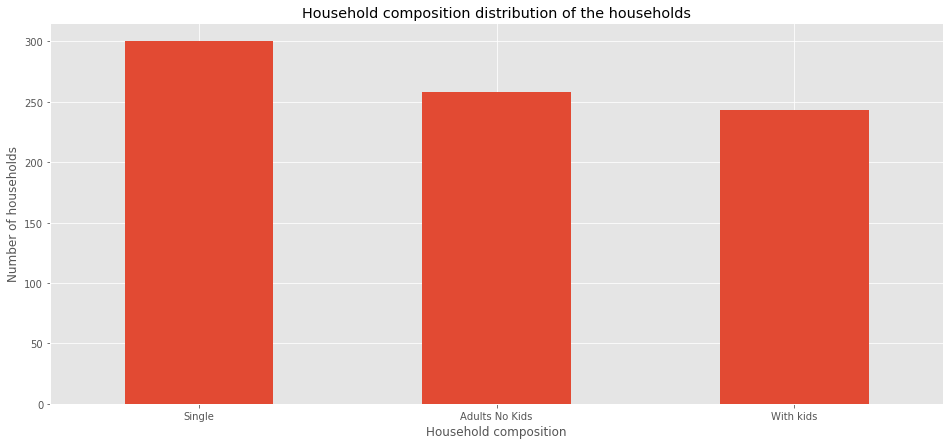

In [65]:
df_demo["hh_comp_desc"].value_counts().plot(kind="bar")
plt.xlabel('Household composition')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Number of households')
plt.title('Household composition distribution of the households')
plt.show()

# Transactions

The main aspect of the dataset is the list of all transcations the households have done. In this section, we will focus ourselfs on the prices of the products. We will start by some basic statistical analysis and then group products in the previously defined categories and try to extract some meaningful conclusions.

In [66]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')
df_transaction.columns = map(str.lower, df_transaction.columns)
df_transaction.head()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


First, how many households do we have?

In [67]:
number_households = len(df_transaction["household_key"].unique())
print('The dataset contains {} individual households.'.format(number_households))

The dataset contains 2500 individual households.


Let's clarify what the less obvious columns represent. The *sales_value* is the amount of dollar received by the retailer for a particular sale. The *retail_disc* is a discount applied due to retailer's loyalty card program. The *coupon_disc* is a discount applied due to manufacturer coupon and *coupon_match_disc* a discount applied due to retailer's match of manufacturer coupon. Finally, the *trans_time* corresponds to the time of the day the purchase was made (ranging from 0 to 2359, i.e. from 0:00 to 23:59)

In [68]:
print('We have %d transactions in our dataset.' %len(df_transaction))
print('We have %d transactions in our dataset with QUANTITY = 0.' %len(df_transaction[df_transaction.quantity == 0]))

We have 2595732 transactions in our dataset.
We have 14466 transactions in our dataset with QUANTITY = 0.


We start by discarding all transcations for which the quantity is null (as no item has actually been sold in these cases).

In [69]:
df_transaction = df_transaction[df_transaction.quantity > 0]
print('We have %d transactions left in our dataset.' %len(df_transaction))

We have 2581266 transactions left in our dataset.


Let's add the actual product prices (with or without loyalty card). To do so, we use the following formulas (as explained in the user guide):
- Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity
- Non-loyalty card price = (sales_value – coupon_match_disc)/quantity

In [70]:
df_transaction['loyalty_card_price'] = (df_transaction['sales_value'] - (df_transaction['retail_disc'] + df_transaction['coupon_match_disc']))/df_transaction['quantity']
df_transaction['no_loyalty_card_price'] = (df_transaction['sales_value'] - df_transaction['coupon_match_disc'])/df_transaction['quantity']
df_transaction.head()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,loyalty_card_price,no_loyalty_card_price
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.99,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1.29,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.89,1.50


## Descriptive statistics

### Sales value

In [71]:
rp.summary_cont(df_transaction['sales_value'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,sales_value,2581266.0,3.121509,4.187501,0.002606,3.1164,3.126617


In [72]:
print('50% of the transations are below ' + str(df_transaction['sales_value'].median()) + '$.')
print('80% of the transations are below ' + str(df_transaction['sales_value'].quantile(0.8)) + '$.')
print('There are %d transactions with sales value 0.' %len(df_transaction[df_transaction['sales_value'] == 0]))

50% of the transations are below 2.0$.
80% of the transations are below 3.99$.
There are 4451 transactions with sales value 0.


### Actual price (with and without loyalty card)

In [73]:
rp.summary_cont(df_transaction['loyalty_card_price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,loyalty_card_price,2581266.0,2.847515,3.017902,0.001878,2.843834,2.851197


In [74]:
print('50% of the prices (with loyalty card) are below ' + str(df_transaction['loyalty_card_price'].median()) + '$.')
print('80% of the prices (with loyalty card) are below ' + str(df_transaction['loyalty_card_price'].quantile(0.8)) + '$.')

50% of the prices (with loyalty card) are below 2.19$.
80% of the prices (with loyalty card) are below 3.89$.


In [75]:
rp.summary_cont(df_transaction['no_loyalty_card_price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,no_loyalty_card_price,2581266.0,2.439389,2.720552,0.001693,2.436071,2.442708


In [76]:
print('50% of the prices (without loyalty card) are below ' + str(df_transaction['no_loyalty_card_price'].median()) + '$.')
print('80% of the prices (without loyalty card) are below ' + str(df_transaction['no_loyalty_card_price'].quantile(0.8)) + '$.')

50% of the prices (without loyalty card) are below 1.94$.
80% of the prices (without loyalty card) are below 3.27$.


### Discounts (retailer and coupons)

In [77]:
rp.summary_cont(df_transaction['retail_disc'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,retail_disc,2581266.0,-0.541725,1.252032,0.000779,-0.543253,-0.540198


In [78]:
rp.summary_cont(df_transaction['coupon_disc'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,coupon_disc,2581266.0,-0.012507,0.169324,0.000105,-0.012713,-0.0123


In [79]:
rp.summary_cont(df_transaction['coupon_match_disc'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,coupon_match_disc,2581266.0,-0.002935,0.039801,0.000025,-0.002983,-0.002886


### Transaction time

In [80]:
print('The TRANS_TIME ranges between %d and %d.' %(df_transaction['trans_time'].min(), df_transaction['trans_time'].max()))

The TRANS_TIME ranges between 0 and 2359.


## Categories of food

Now let us join the products and transactions data for more insights.

In [81]:
df_food_trans = pd.merge(df_food, df_transaction, on='product_id', how='left')

Let's check what percentile of the households did not buy meat and seafood products at all.

In [82]:
df_meat_seafood = df_meat.append(df_seafood)
df_meat_seafood_trans = pd.merge(df_meat_seafood, df_transaction, on='product_id', how='left')
number_household_meat_seafood = len(df_meat_seafood_trans["household_key"].unique())
number_hh_no_meat_seafood = number_households-number_household_meat_seafood
prop_hh_no_meat_seafood = number_hh_no_meat_seafood/number_households
print("Number of households who did not purchased any meat or seafood: %d (%0.2f%% of the total)" %(number_hh_no_meat_seafood, prop_hh_no_meat_seafood))

Number of households who did not purchased any meat or seafood: 22 (0.01% of the total)


Let's have a look at the meat and seafood weekly transactions.

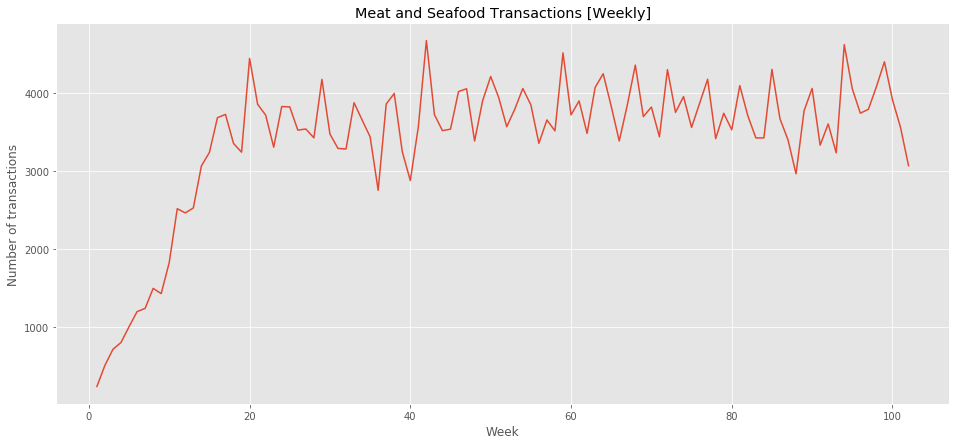

In [83]:
weekly_meat_sea = df_meat_seafood_trans.groupby("week_no").count()["product_id"]
weekly_trans = df_food_trans.groupby("week_no").count()["product_id"]
plt.plot(weekly_meat_sea)
plt.xlabel("Week")
plt.ylabel("Number of transactions")
plt.title("Meat and Seafood Transactions [Weekly]")
plt.show()

Overall there is no upwards or downwards trend of meat and seafood transactions. But it is weird that the meat and seafood transactions rose rapidly in the first few weeks. It is likely that in the beginning not all transactions were caught. We take a look at the relation between the number of transactions and the number of meat and seafood transactions. If the rise in the beginning is only due to the fact that not all transactions were recorded, then the relation should be linear.

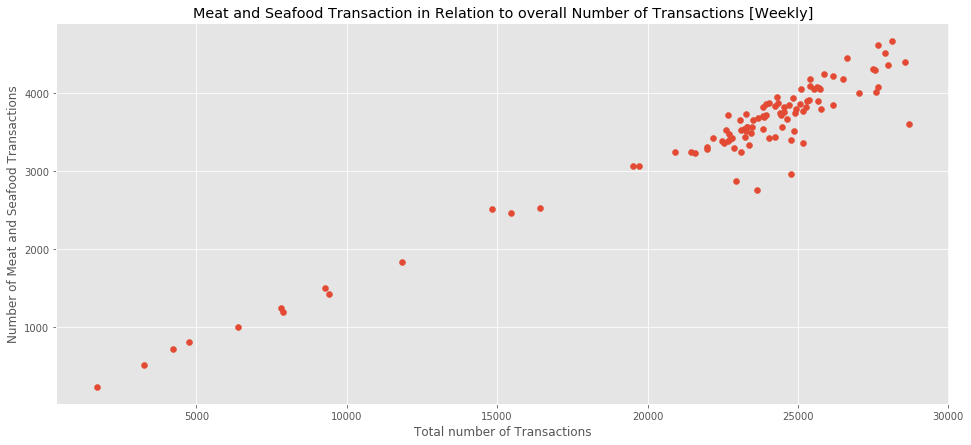

In [84]:
plt.scatter(weekly_trans, weekly_meat_sea)
plt.xlabel("Total number of Transactions")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transaction in Relation to overall Number of Transactions [Weekly]")
plt.show()

The relation is indeed linear.

Next we take a look at the number of households which weekly buy meat or seafood products.

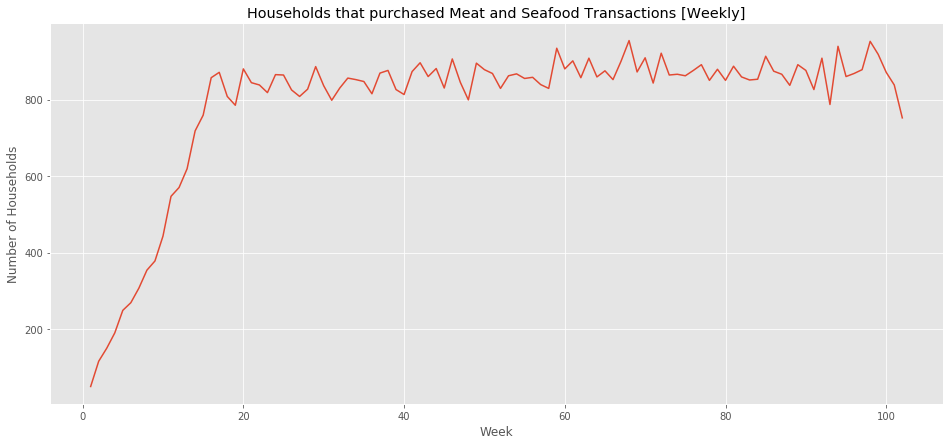

In [85]:
plt.plot(df_meat_seafood_trans.groupby("week_no")["household_key"].nunique())
plt.xlabel("Week")
plt.ylabel("Number of Households")
plt.title("Households that purchased Meat and Seafood Transactions [Weekly]")
plt.show()

The number again stays relatively stable at around 800-900. That is surprising, because the number of households which did purchase a meat product in the two years is 2475.

Let's check the number of households, which go vegetarian in a week.

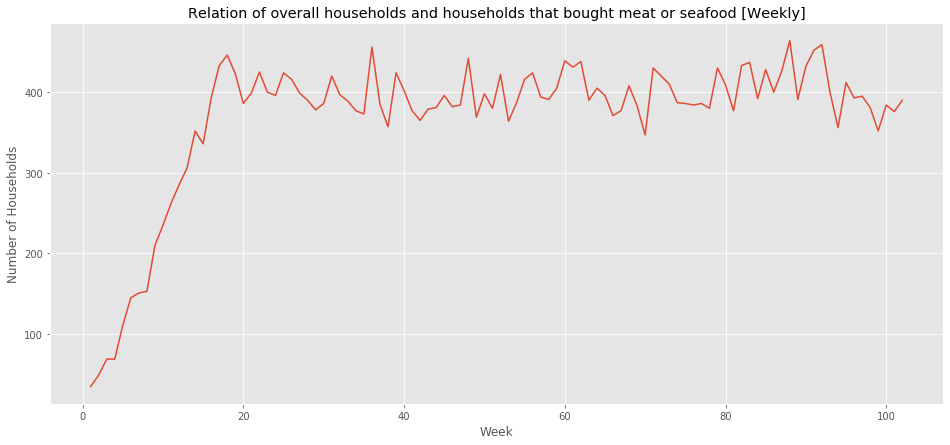

In [86]:
weekly_vege = df_food_trans.groupby("week_no")["household_key"].nunique()-df_meat_seafood_trans.groupby("week_no")["household_key"].nunique()
plt.plot(weekly_vege)
plt.xlabel("Week")
plt.ylabel("Number of Households")
plt.title("Relation of overall households and households that bought meat or seafood [Weekly]")
plt.show()

Surprisingly the number is super high considering that almost all households do not live completely vegetarian. Lets check the frequency of the meat and seafood purchases of all households.

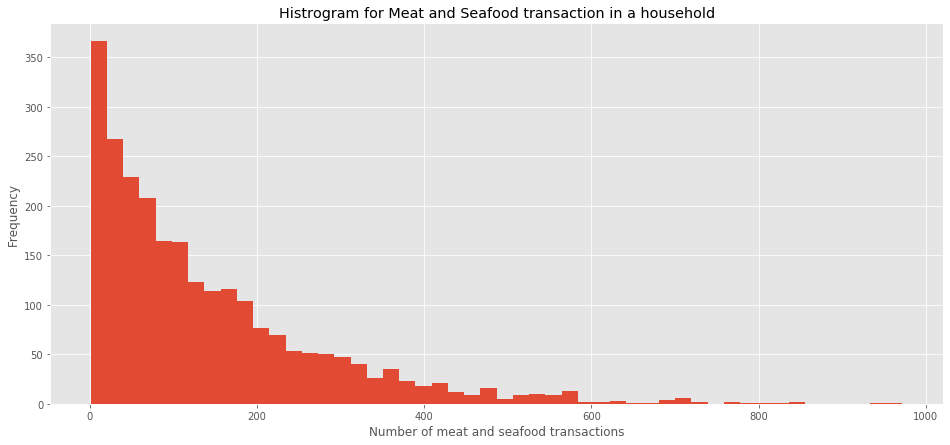

In [87]:
house_purchase = df_meat_seafood_trans.groupby("household_key").count()["product_id"]
#print(house_purchase.sort_values(ascending=False).head(10))
plt.hist(house_purchase, bins=50)
plt.xlabel("Number of meat and seafood transactions")
plt.ylabel("Frequency")
plt.title("Histrogram for Meat and Seafood transaction in a household")
plt.show()

<div style="border:1px solid black; padding:30px 30px; background-color: #3388FF; text-align: center; font-size:30px;">
   <strong>Demographics and Food</strong>
</div>

In this section, we want to find out if there are **different consumptions behaviours** between **different groups of people** (based on their age, their income and the household composition). To do so, we will combine the informations from the demographic dataframe and the transactions. 

In [88]:
#Merge the transactions with the demographics informations
df_transaction_per_household = df_transaction.merge(df_demo, on="household_key")

#Assign a category to each transaction
df_transaction_per_household["category"] = "Unknown"
#Let's mark everything with the corresponding category
for categ,df in enumerate(df_list):
    df_transaction_per_household.loc[
        df_transaction_per_household["product_id"].isin(df["product_id"]), "category"
    ] = categories[categ]

#Check: we should only have products of the 11 categories previously designed
df_transaction_per_household.category.unique()

array(['Sweet snacks', 'Meat', 'Veg animal', 'Other', 'Carbs',
       'Condiments', 'Vegetables', 'Meals', 'Seafood', 'Fruits',
       'Beverage'], dtype=object)

Now let's add the sizes of the products.

In [89]:
df_transaction_per_household = df_transaction_per_household.merge(df_products[["product_id","curr_size_of_product", "sub_commodity_desc"]], 
                                                                  on="product_id")

We also create a dataframe with the ratio of transactions in each category for each household.

In [90]:
#Create the dataframe
ratio_df = (
    df_transaction_per_household.groupby("household_key")["category"]
    .value_counts()
    .to_frame()
    .unstack()
)
#If a household has no transactions in a given category, the count will be set to NaN, we simple fill with 0
ratio_df.fillna(0, inplace = True)

# Drop the multi-columns, so we can use simple indexing for ratio_meat 
ratio_df.columns = ratio_df.columns.droplevel()

#Compute the ratios for each category of food
ratio_df['Total'] = 0
for categ in categories:
    ratio_df['Total'] += ratio_df[categ]
for categ in categories:
    #name = 'ratio ' + categ.lower()
    ratio_df[categ] = ratio_df[categ] / ratio_df["Total"]

# Get household_key as a column
ratio_df.reset_index(inplace = True)

# Meat consumption

Let's focus on meat consumption first. We create a dataframe *df_meat_per_household* with only food, dropping all transactions with no sizes of the product bought.

In [91]:
df_meat_per_household = df_transaction_per_household[df_transaction_per_household["category"] == "Meat"]
df_meat_per_household = df_meat_per_household[df_meat_per_household.curr_size_of_product != " "]

We design some utility functions to treat the sizes of product (since there are many different types). To do so, we use the libraries *measurement* and *fractions*.

In [92]:
from measurement import utils
from fractions import Fraction

In [93]:
import re, math

simple_oz_rex = re.compile(r".*?(\d*\.?\d*)\s*(oz|ounce)")
simple_lb_rex = re.compile(r".*?(\d*\.?\d*)\s*lb")
oz_fractional_rex = re.compile(r"(\d+)\s+(\d+\/\d+)\s*oz")

#Parse the sizes in a more manageable format
def parse_size(size):
    size = size.lower()
    
    match = oz_fractional_rex.match(size)
    if match:
        whole = match.group(1)
        fraction = float(Fraction(match.group(2)))
        
        return (int(whole) + fraction, "oz")
    
    match = simple_oz_rex.match(size)
    if match:
        return (match.group(1), "oz")
    
    match = simple_lb_rex.match(size)
    if match:
        return (match.group(1), "lb")
    
    return np.nan

#Transform american units into kg
def fix_size(size):
    clean_size = parse_size(size)
    
    if not isinstance(clean_size, tuple) and math.isnan(clean_size):
        return np.nan
    
    if isinstance(clean_size, float):
        print("---_>>>>>", clean_size)
        
    return utils.guess(*clean_size).kg

Let's apply these functions to our meat dataframe to obtain the total weight (in kg) of meat bought by each household.

In [94]:
#Get the equivalent weight of each meat product bought
df_meat_per_household["weight(kg)"] = df_meat_per_household.curr_size_of_product.apply(fix_size)
#Group by household_key to get the total amount of meat (in kg) bought by each household
weight_meat_per_household = df_meat_per_household.groupby("household_key")[["weight(kg)"]].sum()

Then we add the duration, i.e. the number of days between the first and the last transaction for meat, for each household.

In [95]:
weight_meat_per_household["duration(days)"] = (
    df_meat_per_household.groupby("household_key")["day"].max()
    - df_meat_per_household.groupby("household_key")["day"].min()
    + 1
)

Let's check we don't have any null durations.

In [96]:
number_null_duration = len(weight_meat_per_household["duration(days)"][weight_meat_per_household["duration(days)"] == 0].index.values)
print('We have %d households with a null duration in our database.' %number_null_duration)
#weight_meat_per_household.drop(index=invalid_duration_hhkey, inplace=True)

We have 0 households with a null duration in our database.


We will transform the meat ratio in the weight of meat bought per day by each household.

In [97]:
# Combine our newly computed ratio_meat and the old household data
df_demo_w_meat = df_demo.merge(ratio_df[["household_key", "Meat"]], on="household_key")

# Normalize our ratio_meat by the size of the households
df_demo_w_meat["ratio meat"] = df_demo_w_meat["Meat"]/df_demo_w_meat["household_size_desc_numeric"]

# Combine it with the weight
df_demo_w_meat = df_demo_w_meat.merge(weight_meat_per_household, on="household_key")

# Normalize the same way we did 
df_demo_w_meat["weight(kg)"] /= df_demo_w_meat["household_size_desc_numeric"]
df_demo_w_meat["weight(kg/day)"] = df_demo_w_meat["weight(kg)"] / df_demo_w_meat["duration(days)"]

df_demo_w_meat[['household_key', 'age_desc', 'hh_comp_desc', 'income_desc', 'ratio meat', 'weight(kg/day)']]

,household_key,age_desc,hh_comp_desc,income_desc,ratio meat,weight(kg/day)
0,1,65+,Adults No Kids,35-49K,0.043567,0.044752
1,7,45-54,Adults No Kids,50-74K,0.059375,0.043415
2,8,25-34,With kids,25-34K,0.045247,0.064681
3,13,25-34,With kids,75-99K,0.014937,0.021219
4,16,45-54,Single,50-74K,0.129594,0.042869
...,...,...,...,...,...,...
795,2494,35-44,Adults No Kids,50-74K,0.050654,0.016317
796,2496,45-54,With kids,75-99K,0.070543,0.032399
797,2497,45-54,Single,35-49K,0.107252,0.143074
798,2498,25-34,Adults No Kids,50-74K,0.038999,0.039363


Now to get a sense of the data, we'll plot it (grouped by three different attributes: household composition, age and income). To do so, we define a function *plot_categ_groups()* that takes the dataframe from which we want to plot our data, the category we are interested in and the criteria to split the households into different groups. This function is general and can be applied to any dataframe, as long as the format is correct (each household has a tag to assign it to a group and the quantity to plot for the category of food we are interested in). Note the *y_label* also has to be specified in order to make this function as general as possible.

In [98]:
def plot_categ_groups(df, categ, group, y_label, title):
    #Get the data to plot
    data = df.groupby(group).mean()[categ]
    #Compute the errors on the means with bootstrap resampling
    means = []
    for _ in range(500):
        bs_resample_per_group = df.groupby(group).apply(
            lambda x: x.sample(frac=1.0, replace=True)
        )

        bs_mean = bs_resample_per_group[categ].groupby(group).mean()

        means.append(bs_mean)
    means = pd.DataFrame(means)

    qupper = means.quantile(0.975)
    qlower = means.quantile(0.025)
    
    #Order the income indexes
    if group == "income_desc":
        data = data.reindex(salary_index)
        
    #Plot the data
    dict_group = {'hh_comp_desc':'Household composition',
                  'age_desc':'Age',
                  'income_desc':'Income'}    
    data.plot.bar(yerr=[data - qlower, qupper - data], capsize=10)
    plt.xticks(rotation = 'horizontal')
    plt.xlabel(dict_group[group])
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [130]:
import seaborn as sns

In [168]:
aa = df_demo_w_meat.melt(
    value_vars="weight(kg/day)",
    value_name="weight(kg/day)",
    id_vars=["married", "age_desc", "income_desc"],
)
aa

,married,age_desc,income_desc,variable,weight(kg/day)
0,Married,65+,35-49K,weight(kg/day),0.044752
1,Married,45-54,50-74K,weight(kg/day),0.043415
2,Unknown,25-34,25-34K,weight(kg/day),0.064681
3,Unknown,25-34,75-99K,weight(kg/day),0.021219
4,Single,45-54,50-74K,weight(kg/day),0.042869
...,...,...,...,...,...
795,Unknown,35-44,50-74K,weight(kg/day),0.016317
796,Married,45-54,75-99K,weight(kg/day),0.032399
797,Unknown,45-54,35-49K,weight(kg/day),0.143074
798,Unknown,25-34,50-74K,weight(kg/day),0.039363


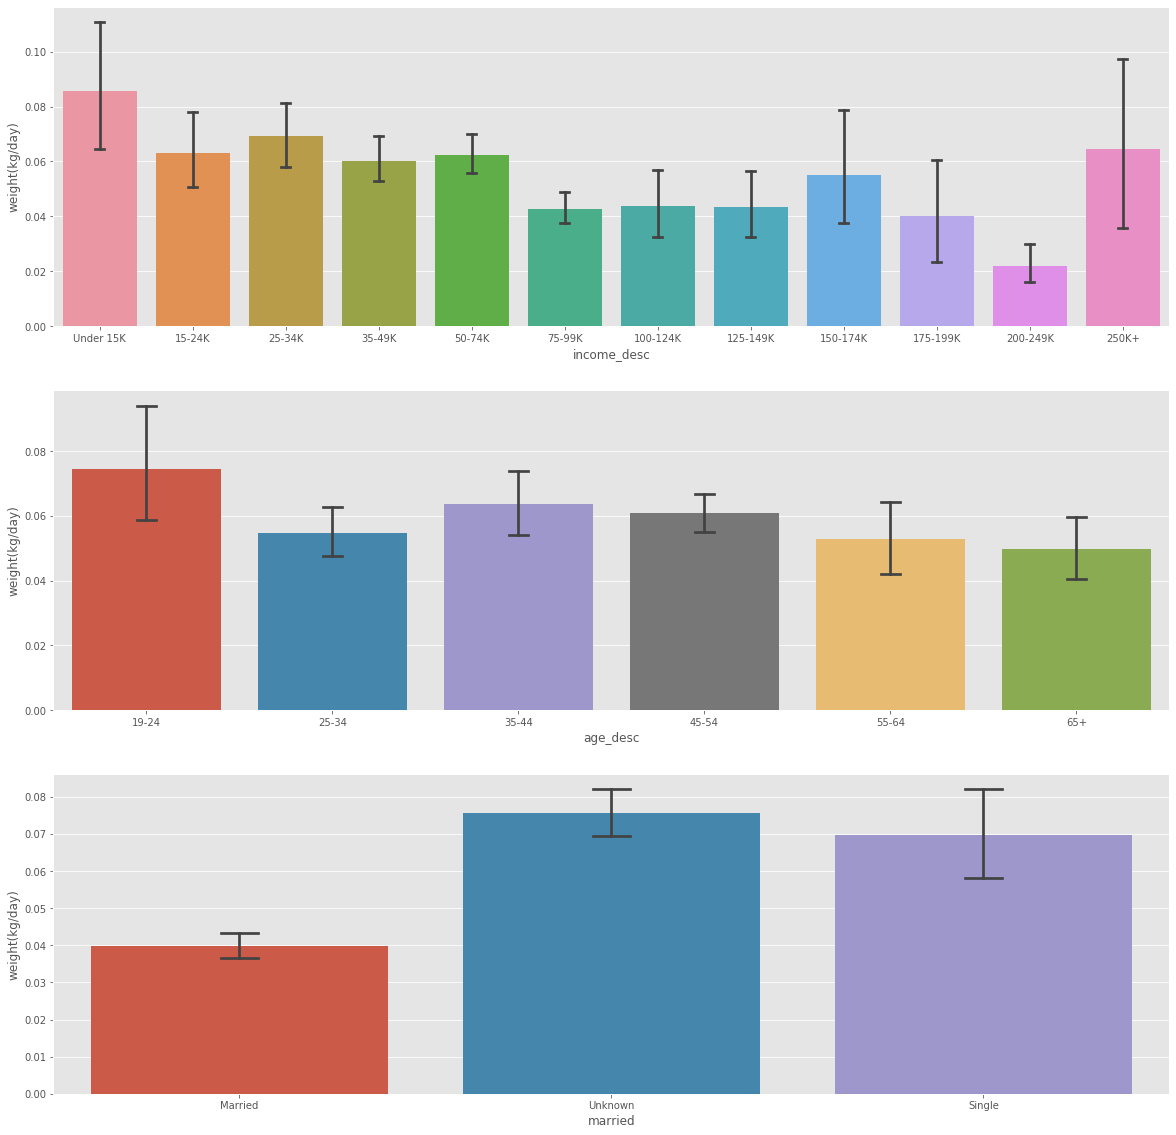

In [177]:
figsize_before = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (20,20)

fig, axes = plt.subplots(nrows=3)

sns.barplot(
    x="income_desc",
    y="weight(kg/day)",
    data=aa,
    capsize=0.1,
    ci=95,
    order=salary_index,
    ax=axes[0],
)
sns.barplot(
    x="age_desc",
    y="weight(kg/day)",
    data=aa,
    capsize=0.1,
    ci=95,
    ax=axes[1],
    order=[
        "19-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65+"
    ]
)
sns.barplot(
    x="married",
    y="weight(kg/day)",
    data=aa,
    capsize=0.1,
    ci=95,
    ax=axes[2],
)

plt.show()
plt.rcParams["figure.figsize"] = figsize_before

In [146]:
df_demo_w_meat

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric,Meat,ratio meat,weight(kg),duration(days),weight(kg/day)
0,65+,A,35-49K,Homeowner,Adults No Kids,2,None/Unknown,1,Married,2,0.087135,0.043567,29.357325,656,0.044752
1,45-54,A,50-74K,Homeowner,Adults No Kids,2,None/Unknown,7,Married,2,0.118750,0.059375,29.478873,679,0.043415
2,25-34,U,25-34K,Unknown,With kids,3,1,8,Unknown,3,0.135740,0.045247,41.524930,642,0.064681
3,25-34,U,75-99K,Homeowner,With kids,4,2,13,Unknown,4,0.059747,0.014937,12.646287,596,0.021219
4,45-54,B,50-74K,Homeowner,Single,1,None/Unknown,16,Single,1,0.129594,0.129594,18.305272,427,0.042869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,35-44,U,50-74K,Homeowner,Adults No Kids,2,None/Unknown,2494,Unknown,2,0.101307,0.050654,9.610480,589,0.016317
796,45-54,A,75-99K,Homeowner,With kids,3,1,2496,Married,3,0.211629,0.070543,18.370004,567,0.032399
797,45-54,U,35-49K,Unknown,Single,1,None/Unknown,2497,Unknown,1,0.107252,0.107252,87.704281,613,0.143074
798,25-34,U,50-74K,Homeowner,Adults No Kids,2,None/Unknown,2498,Unknown,2,0.077998,0.038999,16.571842,421,0.039363


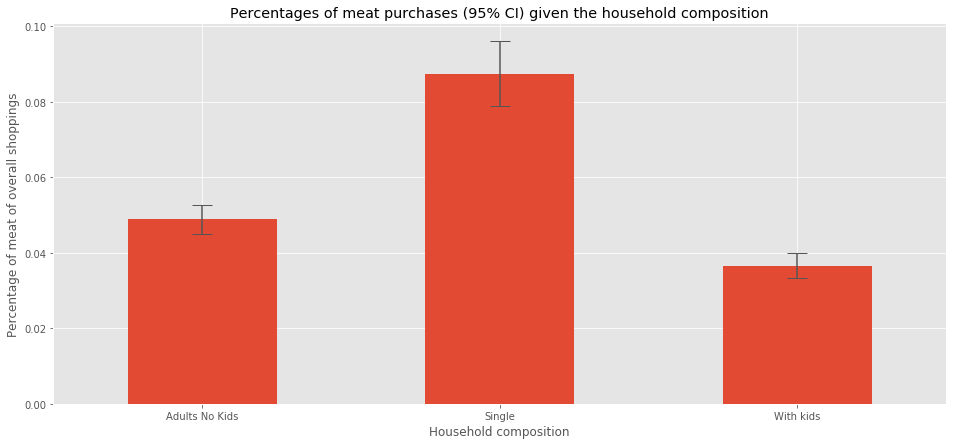

In [99]:
plot_categ_groups(df_demo_w_meat, 'weight(kg/day)', 'hh_comp_desc', 
                  'Percentage of meat of overall shoppings', 
                  'Percentages of meat purchases (95% CI) given the household composition')

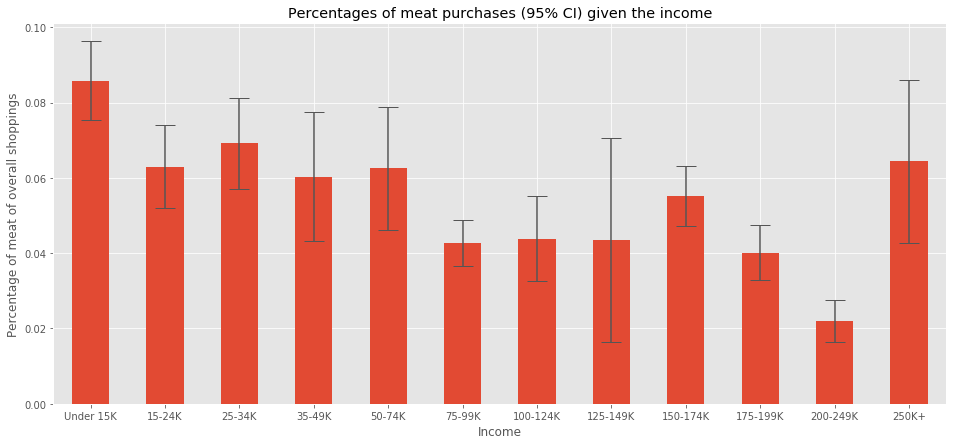

In [100]:
plot_categ_groups(df_demo_w_meat, 'weight(kg/day)', 'income_desc', 
                  'Percentage of meat of overall shoppings', 
                  'Percentages of meat purchases (95% CI) given the income')

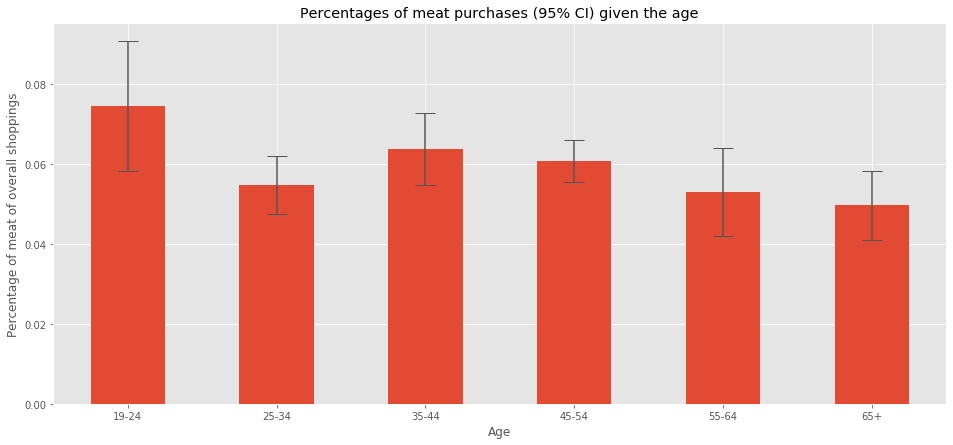

In [101]:
plot_categ_groups(df_demo_w_meat, 'weight(kg/day)', 'age_desc', 
                  'Percentage of meat of overall shoppings', 
                  'Percentages of meat purchases (95% CI) given the age')

We see some interesting things:

* Single people buy a lot more meat than households with multiple people
* As the income rises, the amount of meat bought decreases. It then sharply increases for incomes of over 250k
* There do not seem to be any notable differences among groups of different ages

To confirm our results, we will run some statistical tests (ANOVA or its non-parametric alternative, the Kruskal-Wallis test).

## ANOVA test
The following section is based on the explanations of https://pythonfordatascience.org/anova-python/ by Corey Bryant.

The ANOVA test can be thought as an extension of the t-test. The goal is to compare the means of a condition among more than 2 groups. Note that ANOVA is an omnibus test: it tests the data as a whole, meaning it won't specifically say where the differences betwen groups are but only if there are some differences. The hypothesis being tested are:
* H0: the means of all the groups are the same
* H1: the means of some groups are not the same

Mathematically speaking, ANOVA is a generalized linear model with the following general regression equation: 
\begin{equation}
outcome_i = (model) + error_i
\end{equation}
where (model) is of the form:
\begin{equation}
model = \Sigma_{i = 1}^{N-1} b_i group_i + b_0
\end{equation}
with $b_0$ the intercept and N the number of groups. $error_i$ is the error of the model. Notice the sum only goes up to N-1 as one group must be taken as the intercept.

The assumptions that need to be met are:
* normality
* homoscedasticity (ie homogeneity of variances)
* independent observations

To test the normality, we use the Shapiro-Wilk's test. The hypothesis for this test are the following:
* H0: the sample tested come from a normally distributed population
* H1: the sample tested does not come from a normally distributed population

To test the homescedasticity, we use the Levene's test. The hypothesis for this test are the following:
* H0: the variances of the groups tested are the same
* H1: the variances of the groups tested are not the same

If any of the p-value for the Shapiro-Wilk's or Levene's tests are smaller than the chosen confidence level (here 0.05), the corresponding null hypothesis has to be rejected, meaning the assumptions are not met. In that case, we will use the non-parametric alternative of the ANOVA test, the Kruskal-Wallis test. The hypothesis being tested are:
* H0: the samples tested come from the same distribution (ie the means are the same)
* H1: the samples tested do not come from the same distribution (ie the means are not the same)

The following function provided by the author of the article, Corey Bryant, extends the ANOVA table with the mean squares and the effect sizes (the eta-squared, or R2, and the omega-square, or extended R2). Eta-squared and omega-squared share the same suggested ranges for low (0.01 – 0.059), medium (0.06 – 0.139), and large (0.14+) effect size classification (see https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00863/full).

In [102]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

## ANOVA test for the meat consumption depending on the household composition

Let's start by creating a dataframe with just the household composition (our categorial independent variable) and the weight(kg/day) (our continuous dependent variable).

In [103]:
data_hh_comp = df_demo_w_meat[['hh_comp_desc', 'weight(kg/day)']]
#Need to change the name because ols does not recognize the parenthesis
data_hh_comp = data_hh_comp.rename(columns = {'weight(kg/day)':'meat_weight'}) 

The function summary_cont() in the researchpy library provides some useful descriptive statistics.

In [104]:
rp.summary_cont(data_hh_comp.groupby('hh_comp_desc')['meat_weight'])

,N,Mean,SD,SE,95% Conf.,Interval
hh_comp_desc,,,,,,
Adults No Kids,258,0.048845,0.033383,0.002078,0.044764,0.052927
Single,300,0.087478,0.072167,0.004167,0.079298,0.095658
With kids,242,0.036608,0.029715,0.001910,0.032857,0.040360


Let's create the model for the ANOVA test and fit it. Remember one of the group will be treated as the intercept.

In [105]:
model_hh_comp = ols('meat_weight ~ C(hh_comp_desc)', data=data_hh_comp)
results_hh_comp = model_hh_comp.fit()
results_hh_comp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            meat_weight   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     75.75
Date:                Fri, 20 Dec 2019   Prob (F-statistic):           7.59e-31
Time:                        17:01:18   Log-Likelihood:                 1250.3
No. Observations:                 800   AIC:                            -2495.
Df Residuals:                     797   BIC:                            -2481.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0488      0.003     15.446      0.000       0.043       0.055
C(hh_comp_desc)[T.Single]        0.0386      0.004      8.957      0.000       0.030       0.047
C(hh_comp_desc)[T.With kids]    -0.0122      0.005     -2.692      0.007      -0.021      -0.003
==============================================================================
Omnibus:                      465.395   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5185.184
Skew:                           2.438   Prob(JB):                         0.00
Kurtosis:                      14.479   Cond. No.                         3.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Overall the results of the test (F[2.797]=76.01, p-value=6.12e-31) indicate that the null hypothesis can be rejected: there are some significant differences between the groups tested.

In [106]:
aov_table_hh_comp = sm.stats.anova_lm(results_hh_comp, typ=2)
anova_table(aov_table_hh_comp)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(hh_comp_desc),0.390921,2.0,0.195461,75.753895,7.591743e-31,0.159733,0.157458
Residual,2.056423,797.0,0.002580,NaN,NaN,NaN,NaN


We see that both the eta and omega squares have a large effect size (more than 0.14).

#### Check assumptions
We need to check the normality and the homoscedasticity of the residuals.

The Shapiro-Wilk's test tests the null hypothesis that the residuals are normally distributed. The results of this test (W=0.83, p-value=1.79e-28) indicates the null hypothesis has to be rejected.

In [107]:
stats.shapiro(results_hh_comp.resid)

(0.8290135860443115, 2.2256925142876024e-28)

The Levene test tests the null hypothesis that the samples have homegeneous variances. The results of this test (W=41.9, p-value=4.79e-18) indicates the null hypothesis has to be rejected.

In [108]:
stats.levene(data_hh_comp[data_hh_comp.hh_comp_desc == 'Adults No Kids']['meat_weight'], 
             data_hh_comp[data_hh_comp.hh_comp_desc == 'With kids']['meat_weight'],
             data_hh_comp[data_hh_comp.hh_comp_desc == 'Single']['meat_weight'])

LeveneResult(statistic=42.12123074304049, pvalue=4.079606233140869e-18)

Since the assumptions are not met, we use the Kruskal-Wallis test (non-parametric alternative of ANOVA).

In [109]:
stats.kruskal(data_hh_comp[data_hh_comp.hh_comp_desc == 'Adults No Kids']['meat_weight'], 
              data_hh_comp[data_hh_comp.hh_comp_desc == 'With kids']['meat_weight'],
              data_hh_comp[data_hh_comp.hh_comp_desc == 'Single']['meat_weight'])

KruskalResult(statistic=132.8461612486608, pvalue=1.4217479602055838e-29)

The results of the test (H=133.8, p-value=9.02e-30) show that the null hypothesis can be rejected, meaning there are significant differences between the groups.

We will now run some post-hoc tests to find where the significant differences are. To do so, we use the Tukey's HSD method that controls for familywise error rate (different method than the classical Bonferroni). The group1 and group2 columns state which groups are being compared, the meandiff column gives the mean difference of the two groups (computed as group2_mean - group1_mean). The p-adj column gives the p-value (note the familywise error is kept at FWER=0.05). The lower and upper colums give the 95% confidence interval for the mean differences and the reject column states if the null hypothesis must be rejected or not.

In [110]:
mc_hh_comp = MultiComparison(data_hh_comp['meat_weight'], data_hh_comp['hh_comp_desc'])
mc_results_hh_comp = mc_hh_comp.tukeyhsd()
print(mc_results_hh_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1       group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
Adults No Kids    Single   0.0386  0.001  0.0285  0.0488   True
Adults No Kids With kids  -0.0122 0.0198 -0.0229 -0.0016   True
        Single With kids  -0.0509  0.001 -0.0612 -0.0406   True
---------------------------------------------------------------


We see that there is a significant difference between all the groups.

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : Since the assumptions were not met, a Kruskall-Wallis test is conducted. The results of the test (H=133.8, p-value=9.02e-30) show that the null hypothesis can be rejected, meaning there are significant differences between the groups. The post-hoc Tukey's HSD method is used to find where the differences are. The results state that: 
   <ul>
       <li>single people buy more meat than people with no kids (difference of means: 0.0388, p-value=0.001)</li>
       <li>single people buy more meat than people with kids (difference of means: 0.0511, p-value=0.001)</li>
       <li>people with no kids buy more meat than the adults with kids (difference of means: 0.0122, p-value=0.0202)</li>
   </ul>
</div>

## ANOVA test for the meat consumption depending on income 

Let's start by creating a dataframe with just the income description (our categorial independent variable) and the weight(kg/day) (our continuous dependent variable).

In [111]:
data_income = df_demo_w_meat[['income_desc', 'weight(kg/day)']]
data_income = data_income.rename(columns = {'weight(kg/day)':'meat_weight'})

Let's observe some descriptive statistics on our groups.

In [112]:
rp.summary_cont(data_income.groupby('income_desc')['meat_weight'])

,N,Mean,SD,SE,95% Conf.,Interval
income_desc,,,,,,
100-124K,34,0.043894,0.035247,0.006045,0.031868,0.055920
125-149K,38,0.043598,0.038694,0.006277,0.031130,0.056066
15-24K,74,0.062973,0.061224,0.007117,0.048928,0.077018
150-174K,29,0.055155,0.061415,0.011404,0.032407,0.077904
175-199K,11,0.040161,0.033903,0.010222,0.019148,0.061175
200-249K,5,0.022054,0.008896,0.003978,0.013336,0.030772
25-34K,77,0.069154,0.053798,0.006131,0.057058,0.081249
250K+,11,0.064387,0.052738,0.015901,0.031700,0.097075
35-49K,172,0.060318,0.055266,0.004214,0.052034,0.068601


We can now create the model and fit it.

In [113]:
model_income = ols('meat_weight ~ C(income_desc)', data=data_income)
results_income = model_income.fit()
results_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            meat_weight   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.345
Date:                Fri, 20 Dec 2019   Prob (F-statistic):           0.000159
Time:                        17:01:19   Log-Likelihood:                 1198.9
No. Observations:                 800   AIC:                            -2374.
Df Residuals:                     788   BIC:                            -2318.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0439      0.009      4.699      0.000       0.026       0.062
C(income_desc)[T.125-149K]     -0.0003      0.013     -0.023      0.982      -0.026       0.025
C(income_desc)[T.15-24K]        0.0191      0.011      1.691      0.091      -0.003       0.041
C(income_desc)[T.150-174K]      0.0113      0.014      0.818      0.414      -0.016       0.038
C(income_desc)[T.175-199K]     -0.0037      0.019     -0.198      0.843      -0.041       0.033
C(income_desc)[T.200-249K]     -0.0218      0.026     -0.837      0.403      -0.073       0.029
C(income_desc)[T.25-34K]        0.0253      0.011      2.252      0.025       0.003       0.047
C(income_desc)[T.250K+]         0.0205      0.019      1.085      0.278      -0.017       0.058
C(income_desc)[T.35-49K]        0.0164      0.010      1.606      0.109      -0.004       0.036
C(income_desc)[T.50-74K]        0.0186      0.010      1.839      0.066      -0.001       0.039
C(income_desc)[T.75-99K]       -0.0012      0.011     -0.113      0.910      -0.023       0.020
C(income_desc)[T.Under 15K]     0.0419      0.012      3.595      0.000       0.019       0.065
==============================================================================
Omnibus:                      469.558   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4617.024
Skew:                           2.522   Prob(JB):                         0.00
Kurtosis:                      13.634   Cond. No.                         19.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Overall the results of the test (F[11.788]=3.356, p-value=0.000152) indicate that the null hypothesis can be rejected: there are some significant differences between the groups tested.

In [114]:
aov_table_income = sm.stats.anova_lm(results_income, typ=2)
anova_table(aov_table_income)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(income_desc),0.109171,11.0,0.009925,3.344738,0.000159,0.044608,0.031233
Residual,2.338174,788.0,0.002967,NaN,NaN,NaN,NaN


We see that both the eta and omega squares have a low effect size.

#### Check assumptions
We need to check the normality and the homoscedasticity of the residuals.

The Shapiro-Wilk's test tests the null hypothesis that the residuals are normally distributed. The results of this test (W=0.80, p-value=3.72e-30) indicates the null hypothesis has to be rejected.

In [115]:
stats.shapiro(results_income.resid)

(0.802649974822998, 4.250291159917888e-30)

The Levene test tests the null hypothesis that the samples have homegeneous variances. The results of this test (W=2.97, p-value=0.00073) indicates the null hypothesis has to be rejected.

In [116]:
stats.levene(data_income[data_income.income_desc == 'Under 15K']['meat_weight'], 
             data_income[data_income.income_desc == '15-24K']['meat_weight'],
             data_income[data_income.income_desc == '25-34K']['meat_weight'],
             data_income[data_income.income_desc == '35-49K']['meat_weight'],
             data_income[data_income.income_desc == '50-74K']['meat_weight'],
             data_income[data_income.income_desc == '75-99K']['meat_weight'],
             data_income[data_income.income_desc == '100-124K']['meat_weight'],
             data_income[data_income.income_desc == '125-149K']['meat_weight'],
             data_income[data_income.income_desc == '150-174K']['meat_weight'],
             data_income[data_income.income_desc == '175-199K']['meat_weight'],
             data_income[data_income.income_desc == '200-249K']['meat_weight'],
             data_income[data_income.income_desc == '250K+']['meat_weight'])

LeveneResult(statistic=2.965295379182221, pvalue=0.0007234831493686338)

Since the assumptions are not met, we use the Kruskal-Wallis test (non-parametric alternative of ANOVA).

In [117]:
stats.kruskal(data_income[data_income.income_desc == 'Under 15K']['meat_weight'], 
              data_income[data_income.income_desc == '15-24K']['meat_weight'],
              data_income[data_income.income_desc == '25-34K']['meat_weight'],
              data_income[data_income.income_desc == '35-49K']['meat_weight'],
              data_income[data_income.income_desc == '50-74K']['meat_weight'],
              data_income[data_income.income_desc == '75-99K']['meat_weight'],
              data_income[data_income.income_desc == '100-124K']['meat_weight'],
              data_income[data_income.income_desc == '125-149K']['meat_weight'],
              data_income[data_income.income_desc == '150-174K']['meat_weight'],
              data_income[data_income.income_desc == '175-199K']['meat_weight'],
              data_income[data_income.income_desc == '200-249K']['meat_weight'],
              data_income[data_income.income_desc == '250K+']['meat_weight'])

KruskalResult(statistic=31.909694472627507, pvalue=0.0007885945851989811)

The results of the test (H=32.2, p-value=0.00072) show that the null hypothesis can be rejected, meaning there are significant differences between the groups.

We use again the post-hoc Tukey's HSD method to find out where the differences are. Since the categorial value takes 11 different values, this will perform many tests.

In [118]:
mc_income = MultiComparison(data_income['meat_weight'], data_income['income_desc'])
mc_results_income = mc_income.tukeyhsd()
print(mc_results_income)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------
100-124K  125-149K  -0.0003    0.9 -0.0424 0.0419  False
100-124K    15-24K   0.0191 0.8617 -0.0179 0.0561  False
100-124K  150-174K   0.0113    0.9 -0.0339 0.0564  False
100-124K  175-199K  -0.0037    0.9 -0.0657 0.0582  False
100-124K  200-249K  -0.0218    0.9 -0.1074 0.0637  False
100-124K    25-34K   0.0253 0.5104 -0.0115  0.062  False
100-124K     250K+   0.0205    0.9 -0.0414 0.0824  False
100-124K    35-49K   0.0164    0.9 -0.0171 0.0499  False
100-124K    50-74K   0.0186 0.7689 -0.0146 0.0519  False
100-124K    75-99K  -0.0012    0.9 -0.0369 0.0344  False
100-124K Under 15K   0.0419 0.0178  0.0037 0.0801   True
125-149K    15-24K   0.0194 0.8043 -0.0163  0.055  False
125-149K  150-174K   0.0116    0.9 -0.0325 0.0556  False
125-149K  175-199K  -0.0034    0.9 -0.0646 0.0577  False
125-149K  200-249K  -0.0215    

Out of all these tests, only 3 show there are significant differences:
* 100-124K vs Under 15K (p-value=0.0178) 
* 125-149K vs Under 15K (p-value=0.0103)
* 75-99K vs Under 15K (p-value=0.001)

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : Since the assumptions were not met, a Kruskall-Wallis test is conducted. The results of the test (H=32.2, p-value=0.00072) show that the null hypothesis can be rejected, meaning there are significant differences between the groups. The post-hoc Tukey's HSD method is used to find where the differences are. The results state that:
   <ul>
       <li>the Under 15K group buys more meat than the 100-124K group (difference of means: 0.0419, p-value=0.0178)</li>
       <li>the Under 15K group buys more meat than the 125-149K group (difference of means: 0.0422, p-value=0.0103)</li>
       <li>the Under 15K group buys more meat than the 75-99K group (difference of means: 0.0431, p-value=0.001)</li>
   </ul>
</div>

## ANOVA test for the meat consumption depending on the age

Let's start by creating a dataframe with just the age description (our categorial independent variable) and the weight(kg/day) (our continuous dependent variable).

In [119]:
data_age = df_demo_w_meat[['age_desc', 'weight(kg/day)']]
data_age = data_age.rename(columns = {'weight(kg/day)':'meat_weight'})

In [120]:
rp.summary_cont(data_age.groupby('age_desc')['meat_weight'])

,N,Mean,SD,SE,95% Conf.,Interval
age_desc,,,,,,
19-24,46,0.074436,0.060075,0.008858,0.056883,0.091989
25-34,142,0.054702,0.047539,0.003989,0.046855,0.062549
35-44,194,0.063782,0.070710,0.005077,0.053806,0.073758
45-54,287,0.060763,0.050547,0.002984,0.054905,0.066621
55-64,59,0.052953,0.044246,0.005760,0.041566,0.064340
65+,72,0.049667,0.042792,0.005043,0.039713,0.059621


We can now create our model and fit it.

In [121]:
model_age = ols('meat_weight ~ C(age_desc)', data=data_age)
results_age = model_age.fit()
results_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            meat_weight   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.773
Date:                Fri, 20 Dec 2019   Prob (F-statistic):              0.116
Time:                        17:01:20   Log-Likelihood:                 1185.1
No. Observations:                 800   AIC:                            -2358.
Df Residuals:                     794   BIC:                            -2330.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0744      0.008      9.144      0.000       0.058       0.090
C(age_desc)[T.25-34]    -0.0197      0.009     -2.107      0.035      -0.038      -0.001
C(age_desc)[T.35-44]    -0.0107      0.009     -1.177      0.240      -0.028       0.007
C(age_desc)[T.45-54]    -0.0137      0.009     -1.559      0.119      -0.031       0.004
C(age_desc)[T.55-64]    -0.0215      0.011     -1.978      0.048      -0.043      -0.000
C(age_desc)[T.65+]      -0.0248      0.010     -2.377      0.018      -0.045      -0.004
==============================================================================
Omnibus:                      491.704   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5258.513
Skew:                           2.649   Prob(JB):                         0.00
Kurtosis:                      14.388   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Overall the results of the test (F[5.794]=1.783, p-value=0.114) indicate that the groups do not violate the null hypothesis.

In [122]:
aov_table_age = sm.stats.anova_lm(results_age, typ=2)
anova_table(aov_table_age)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(age_desc),0.027022,5.0,0.005404,1.772973,0.11594,0.011042,0.004808
Residual,2.420322,794.0,0.003048,NaN,NaN,NaN,NaN


We see that both the eta and omega squares have a low effect size.

#### Check assumptions
We need to check the normality and the homoscedasticity of the residuals.

The Shapiro-Wilk's test tests the null hypothesis that the residuals are normally distributed. The results of this test (W=0.78, p-value=1.39e-31) indicates the null hypothesis has to be rejected.

In [123]:
stats.shapiro(results_age.resid)

(0.778298020362854, 1.5642940444330326e-31)

The Levene test tests the null hypothesis that the samples have homegeneous variances. The results of this test (W=1.55, p-value=0.1708) indicates that the groups do not violate the assumption of homoscedasticity.

In [124]:
stats.levene(data_age[data_age.age_desc == '19-24']['meat_weight'], 
             data_age[data_age.age_desc == '25-34']['meat_weight'],
             data_age[data_age.age_desc == '35-44']['meat_weight'],
             data_age[data_age.age_desc == '45-54']['meat_weight'],
             data_age[data_age.age_desc == '55-64']['meat_weight'],
             data_age[data_age.age_desc == '65+']['meat_weight'])

LeveneResult(statistic=1.5446569056778798, pvalue=0.1735347594559774)

Since the assumptions are not met, we use the Kruskal-Wallis test (non-parametric alternative of ANOVA).

In [125]:
stats.kruskal(data_age[data_age.age_desc == '19-24']['meat_weight'], 
             data_age[data_age.age_desc == '25-34']['meat_weight'],
             data_age[data_age.age_desc == '35-44']['meat_weight'],
             data_age[data_age.age_desc == '45-54']['meat_weight'],
             data_age[data_age.age_desc == '55-64']['meat_weight'],
             data_age[data_age.age_desc == '65+']['meat_weight'])

KruskalResult(statistic=10.326495529058775, pvalue=0.0664953733963099)

The results of the test (H=10.4, p-value=0.066) show that the groups do not violate the null hypothesis.

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : Since the assumptions were not met, a Kruskall-Wallis test is conducted. The results of the test (H=10.4, p-value=0.066) show that the groups do not violate the null hypothesis. This means the test is inconclusive to determine if the meat consumption differs depending on the age.
</div>

# Generalization to all categories of food

We now want to generalize these analysis to each category of food, comparing the ratio of products bought in a specific category among different groups (based on their marital status, their income and their age). We apply the Kruskal-Wallis test with the null hypothesis that the amounts of money saved in each category of food are the same across all groups. The results are stored in a dataframe with the statistic, the p-value and whether the null hypothesis is rejected (ie if the p-value is smaller than 0.05) or not. We define two utility functions: *store_results()* outputs the results in the desired way (statistic, p-value, if the null hypothesis can be rejected and the category of food) and *print_statement()* prints the desired statement (descriptive statistics obtained with *summary_cont()* and the results of the statistical test conducted).

In [126]:
def store_results(results, categ):
    dict_results = {'Category':categ,
                    'Statistic':results[0],
                    'p-value':results[1],
                    'Reject':(results[1] < 0.05)}
    return dict_results

Since the print statement with all the details is quite long, the parameter *show_details* allows to only show a summary version stating for each category if there is a significant difference or not.

In [127]:
def print_statement(df, results, IV, categ, show_details = False):
    if show_details:
        print('The descriptive statistics for the %s products are:' %categ.lower())
        print(rp.summary_cont(df.groupby(IV)[categ]))
        print()
        print('The results of the Kruskall-Wallis test for the %s products are:' %categ.lower())
        print(results)
    if results[1] < 0.05:
        print('There is a significant difference among the tested groups for the %s products.' %categ.lower())
    else:
        print('The groups tested do not violate the null hypothesis for the %s products.' %categ.lower())
    print('----------------------------------------------------------')
    print()   

In [128]:
def posthoc_test(df, results, IV):
    for categ in results[results.Reject].Category.values:
        print(f"== '{categ}' =============================")
        
        visited_sets = []
        
        for qtofint_a in df[IV].unique():
            for qtofint_b in df[IV].unique():
                
                pair_set = set([qtofint_a, qtofint_b])
                if pair_set in visited_sets or qtofint_a == qtofint_b:
                    continue
                
                visited_sets.append(pair_set)
                
                df_a = df[df[IV] == qtofint_a]
                df_b = df[df[IV] == qtofint_b]
                
                data_a = df_a[categ]
                data_b = df_b[categ]
                
                stat, pval = stats.mannwhitneyu(data_a, data_b)
                
                status = "Rejected" if pval < 0.05 else " -- "
                
                print(f"{status:>10} (p={pval:.5f}) for '{qtofint_a}' vs '{qtofint_b}'")
        print("")

---

In [129]:
posthoc_test(df_demo_w_ratio, results_hh_comp, 'hh_comp_desc')

NameError: name 'df_demo_w_ratio' is not defined

---

In [ ]:
df_demo_w_ratio = df_demo[["household_key", "hh_comp_desc", "income_desc", "age_desc"]].merge(ratio_df, on="household_key")

In [ ]:
df_demo_w_ratio.to_csv('ratio_demo.csv')

We can now run the Kruskal-Wallis tests to find if there are differences among the groups tested and post-hoc tests with the Tukey's HSD method to locate those differences. Note we have enabled the scrolling for the outputs because the print statements can be extremely long (especially for the income and age groups, due to the high number of groups).

## Household composition

In [ ]:
results_hh_comp = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(df_demo_w_ratio[df_demo_w_ratio.hh_comp_desc == 'Adults No Kids'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.hh_comp_desc == 'Single'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.hh_comp_desc == 'With kids'][categ])
    #Print statement
    print_statement(df_demo_w_ratio, results, 'hh_comp_desc', categ, show_details = True)
    
    #Store the results
    results_hh_comp = results_hh_comp.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(df_demo_w_ratio, results_hh_comp, 'hh_comp_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the ratio of products bought in each category of food by various groups (based on the household composition). Significant differences have been found in the following categories:
    <ul>
      <li>Seafood: statistic=6.72, pvalue=3.4702e-02</li>
      <li>Sweet snacks: statistic=32.14, pvalue=1.049e-07</li>
      <li>Fruits: statistic=6.64, pvalue=3.623e-02</li>
      <li>Vegetables: statistic=13.56, pvalue=1.136e-03</li>
      <li>Beverage: statistic=7.20, pvalue=2.737e-02</li>
    </ul>
    Post-hoc tests have been conducted using the Tukey's HSD method. We report some interesting results (see previous output for an exhaustive list of all the results of the post-hoc tests):
    <ul>
      <li>single people buy more seafood than people with kids (difference of means: 0.0024, p-value=0.0111)</li>
      <li>single people buy more fruits than people with kids (difference of means: 0.0095, p-value=0.0138)</li>
      <li>people with no kids buy more vegetables than people with kids (difference of means: 0.0115, p-value=0.0019)</li>
    </ul>
</div>

## Income

In [ ]:
results_income = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(df_demo_w_ratio[df_demo_w_ratio.income_desc == 'Under 15K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '15-24K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '25-34K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '35-49K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '50-74K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '75-99K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '100-124K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '125-149K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '150-174K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '175-199K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '200-249K'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.income_desc == '250K+'][categ])
    #Print statement
    print_statement(df_demo_w_ratio, results, 'income_desc', categ, show_details = True)
    
    #Store the results
    results_income = results_income.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(df_demo_w_ratio, results_income, 'income_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the ratio of products bought in each category of food by various groups (based on their income). Significant differences have been found in the following categories:
    <ul>
      <li>Meat: statistic=80.35, pvalue=1.263e-12</li>
      <li>Seafood: statistic=20.61, pvalue=3.766e-02</li>
      <li>Fruits: statistic=54.03, pvalue=1.167e-07</li>
      <li>Vegetables: statistic=21.89, pvalue=2.528e-02	</li>
      <li>Veg animal: statistic=26.94, pvalue=4.693e-03</li>
      <li>Beverage: statistic=27.04, pvalue=4.531e-03</li>
      <li>Meals: statistic=19.74, pvalue=4.904e-02</li>
      <li>Other products: statistic=39.98, pvalue=3.613e-05</li>
    </ul>
    Post-hoc tests have been conducted using the Tukey's HSD method. We report the most interesting results (see previous output for an exhaustive list of all the results of the post-hoc tests):
    <ul>
      <li>the 100-124K group buys more money seafood products than the 25-34K group (difference of means: 0.0068, p-value=0.0408)</li>
      <li>the 150-174K group buys more fruits than the 15-24K group (difference of means: 0.0372, p-value=0.001)</li>
      <li>the 100-124K group buys more veg animal products than the 15-24K group (difference of means: 0.0336, p-value=0.0176)</li>
    </ul>
</div>

## Age

In [ ]:
results_age = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(df_demo_w_ratio[df_demo_w_ratio.age_desc == '19-24'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.age_desc == '25-34'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.age_desc == '35-44'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.age_desc == '45-54'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.age_desc == '55-64'][categ],
                            df_demo_w_ratio[df_demo_w_ratio.age_desc == '65+'][categ])
    
    #Print statement
    print_statement(df_demo_w_ratio, results, 'age_desc', categ, show_details = True)
    
    #Store the results
    results_age = results_age.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(df_demo_w_ratio, results_age, 'age_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the ratio of products bought in each category of food by various groups (based on their age). Significant differences have been found in the following categories:
    <ul>
      <li>Fruits: statistic=49.22, pvalue=1.995e-09</li>
      <li>Vegetables: statistic=26.93, pvalue=5.881e-05</li>
      <li>Beverage: statistic=26.59, pvalue=6.865e-05</li>
      <li>Condiments: statistic=22.00, pvalue=5.227e-04</li>
      <li>Carbs: statistic=18.32, pvalue=2.568e-03</li>
      <li>Meals: statistic=30.49, pvalue=1.184e-05</li>
    </ul>
    Post-hoc tests have been conducted using the Tukey's HSD method. We report the most interesting results (see previous output for an exhaustive list of all the results of the post-hoc tests):
    <ul>
      <li>65+ people buy more fruits than 19-24 people (difference of means: 0.0444, p-value=0.001)</li>
      <li>55-64 people buy more vegetables than 19-24 people (difference of means: 0.0321, p-value=0.001)</li>
    </ul>
</div>

<div style="border:1px solid black; padding:30px 30px; background-color: #3388FF; text-align: center; font-size:30px;">
   <strong>Campaign analysis</strong>
</div>

In this section, we want to investigate the campaigns and find out if the products are **equally promoted** or not **across the various categories** of food. If not, this might have an **influence on the consumptions behaviours** of people, encouraging them to buy more products from one category than from another for instance.

# Coupons distributed and redeemed

We will start by looking at the number of coupons distributed and redeemed in each category of food, for each campaign. To do sos, we create a function *products_categories()* taking the number of a campaign and plotting the repartition of products for which coupons were offered and were redeemed based on the categories previously defined. It will also return these 2 repartitions as dictionaries with the proportions of each category as values and the categories as keys. A parameter *show_plot* will enable to show or not the plot (if only the proportions are needed). Note that the proportions for the coupons redeemed are computed as the proportion out of the total number of coupons distributed (i.e. 20% coupons redeemed in 'meat' means that 20% of the coupons distributed were redeemed for 'meat'). This is not the same as saying that 20% of the coupons redeemed were for 'meat'.

In [ ]:
def products_categories(num_camp, show_plot = False):
    proportions_dist = dict.fromkeys(categories)
    proportions_red = dict.fromkeys(categories)
    
    #Compute the number of coupons in each category
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons distributed)
        if num_camp in df.merge(df_coupon, on = 'product_id').groupby(by = 'campaign').count().index:
            proportions_dist[categories[categ]] = df.merge(df_coupon, on = 'product_id').groupby(by = 'campaign').count().loc[num_camp][1] 
        else:
            proportions_dist[categories[categ]] = 0
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons redeemed)    
        if num_camp in df.merge(df_coupon[df_coupon.redeemed], on = 'product_id').groupby(by = 'campaign').count().index:  
            proportions_red[categories[categ]] = df.merge(df_coupon[df_coupon.redeemed],
                                                          on = 'product_id').groupby(by = 'campaign').count().loc[num_camp][1] 
        else:
            proportions_red[categories[categ]] = 0
    
    #Compute the proportion as percentage
        #Compute the total number of coupons distributed
    total = 0
    for i in proportions_dist.values(): 
           total += i 
    if total != 0:
        #Compute proportion of coupons distributed per category
        for key in proportions_dist.keys():
            proportions_dist[key] = 100*proportions_dist[key]/total
        #Compute proportion of coupons redeemed per category (proportion of the total number of coupons distributed)
            proportions_red[key] = 100*proportions_red[key]/total
    
    #Plot the repartitions of products for which coupons were offered
    if show_plot:   
        # set width of bar
        barWidth = 0.4
 
        # Set position of bar on X axis
        r = np.arange(len(proportions_dist))
        r1 = [x - barWidth/2 for x in r]
        r2 = [x + barWidth/2 for x in r]
 
        # Make the plot
        plt.bar(r1, list(proportions_dist.values()), width=barWidth, edgecolor='white', label='Distributed coupons')
        plt.bar(r2, list(proportions_red.values()), width=barWidth, edgecolor='white', label='Redeemed coupons')
        plt.xticks(range(len(proportions_dist)), list(proportions_dist.keys()))
        plt.title('Proportions of coupons per category during campaign ' + str(num_camp))
        plt.xlabel('Categories')
        plt.ylabel('Proportion of coupons [%]')
        plt.legend()
        plt.show()
    
    return (proportions_dist, proportions_red)

Let's see how the coupons distributed are spread over the different categories for campaign 8 for instance.

In [ ]:
(prop_dist, prop_red) = products_categories(8, True)

Let's now take a more overall view, across all campaign. We will compute the proportions of coupons distributed in each category for all campaigns and plot the results in a stacked bar plot.

In [ ]:
proportions_dist_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_dist_overall = proportions_dist_overall.append(products_categories(i+1)[0], ignore_index = True)
proportions_dist_overall.set_index(df_campaign_desc.index, inplace = True)

In [ ]:
proportions_dist_overall.to_csv('prop_dist_overall.csv')

In [ ]:
proportions_dist_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

We can do the same for the proportions of coupons redeemed per category for each campaign. Note that in this case the total will not add to 100% as not all coupons are redeemed during a campaign.

In [ ]:
proportions_red_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_red_overall = proportions_red_overall.append(products_categories(i+1)[1], ignore_index = True)
proportions_red_overall.set_index(df_campaign_desc.index, inplace = True)

In [ ]:
proportions_red_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

## Vegetarian vs non-vegetarian

As one can see, it is still quite hard to understand what is happening. We will thus group products in fewer categories: vegetarian, non-vegetarian, unknown and other. The 'unknown' category comprises all categories were the exact list of ingredients would be needed to know if it is vegetarian or not. We will only plots the vegetarian and non-vegetarian products as they are the most interesting for our analysis.

In [ ]:
proportions_dist_final = pd.DataFrame()
proportions_dist_final['Vegetarian'] = proportions_dist_overall['Fruits'] + proportions_dist_overall['Vegetables'] + proportions_dist_overall['Veg animal'] + proportions_dist_overall['Carbs']
proportions_dist_final['Non-vegetarian'] = proportions_dist_overall['Meat'] + proportions_dist_overall['Seafood']
proportions_dist_final['Unknown'] = proportions_dist_overall['Sweet snacks'] + proportions_dist_overall['Beverage'] + proportions_dist_overall['Condiments'] + proportions_dist_overall['Meals']
proportions_dist_final['Other'] = proportions_dist_overall['Other']

In [ ]:
proportions_dist_final[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True, color = ['#1b9e77', '#d95f02'])
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

It is now clear that there are indeed more coupons distributed for vegetarian products than for non-vegetarian ones. Note however that the proportion of coupons for the unknown category is usually the highest, meaning no absolute conclusion can be made here in the vegetarian vs non-vegetarian debate.

In [ ]:
proportions_red_final = pd.DataFrame()
proportions_red_final['Vegetarian'] = proportions_red_overall['Fruits'] + proportions_red_overall['Vegetables'] + proportions_red_overall['Veg animal'] + proportions_red_overall['Carbs']
proportions_red_final['Non-vegetarian'] = proportions_red_overall['Meat'] + proportions_red_overall['Seafood']
proportions_red_final['Unknown'] = proportions_red_overall['Sweet snacks'] + proportions_red_overall['Beverage'] + proportions_red_overall['Condiments'] + proportions_red_overall['Meals']
proportions_red_final['Other'] = proportions_red_overall['Other']

In [ ]:
proportions_red_final[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True, color = ['#1b9e77', '#d95f02'])
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

As for the proportion of distributed coupons, the proportion of coupons redeemed for vegetarian products is higher than the one for non-vegetarian products.

Let's have a more overall view at the vegetarian vs non-vegetarian proportions of coupons distributed and redeemed.

In [ ]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((proportions_dist_final['Vegetarian'],proportions_dist_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True,
                meanline = True) #Add arithmetic means as dashed line
axes[0].set_title('Coupons distributed')
axes[1].boxplot((proportions_red_final['Vegetarian'],proportions_red_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True,
                meanline = True) #Add arithmetic means as dashed line
axes[1].set_title('Coupons redeemed')

for ax in axes:
    ax.set_xlabel('Category')
    ax.set_ylabel('Proportion of coupons')

fig.suptitle('Vegetarian vs non-vegetarian proportions of coupons (overall view)')
plt.show()

It is hard to have meaningful conclusions at this point since the notches seem to overlap a little.

We define a small utility function *compute_stats()* to compute the mean of a set of data points and its error (at the confidence level of 0.95 by default).

In [ ]:
def compute_stats(data, confidence = 0.95):

    n = len(data)
    m = scipy.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    return (m, h)

Let's summarize our results for the coupons distributed and redeemed in the vegetarian and non-vegetarian categories.

In [ ]:
#Get the coupons distributed and redeemed for the two categories
veg_dist = proportions_dist_final['Vegetarian']
non_veg_dist = proportions_dist_final['Non-vegetarian']
veg_red = proportions_red_final['Vegetarian']
non_veg_red = proportions_red_final['Non-vegetarian']

#Compute stats for vegetarian products (first element: coupons distributed, second element: coupons redeemed)
means_veg = [compute_stats(veg_dist)[0], compute_stats(veg_red)[0]]
err_veg = [compute_stats(veg_dist)[1], compute_stats(veg_red)[1]]
#Compute stats for non-vegetarian products (first element: coupons distributed, second element: coupons redeemed)
means_non_veg = [compute_stats(non_veg_dist)[0], compute_stats(non_veg_red)[0]]
err_non_veg = [compute_stats(non_veg_dist)[1], compute_stats(non_veg_red)[1]]

#Plot the results
barWidth = 0.4
r = np.arange(2)
r1 = [x - barWidth/2 for x in r]
r2 = [x + barWidth/2 for x in r]

plt.bar(x = r1, height = means_veg, width = barWidth, yerr = err_veg, label = 'Vegetarian', capsize=10)
plt.bar(x = r2, height = means_non_veg, width = barWidth, yerr = err_non_veg, label = 'Non-vegetarian', capsize=10)
plt.xticks(np.arange(2), ["Coupons distributed", "Coupons redeemed"], fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Proportion of veg vs non-veg coupons (overall view)", fontsize = 18)
plt.ylabel("Proportion of coupons [%]", fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

## Independent t-test

Let's perform an independent t-test to determine if the differences between the number of coupons distributed for vegetarian and non-vegetarian products are significant.

Let's define a function *t_test()* taking two parameters, being the two lists of elements we want to compare. In this first case, it would be the proportions of coupons distributed in each campaign for vegetarian and non-vegetarian products.

This function first checks the assumptions for the t-test, ie homogeneity of variances (with Levene's test) and normal distribution of residuals (with Shapiro-Wilk's test). If those conditions are met, it proceeds to the t-test using *researchpy.ttest()* method with the parameter *equal_variances* set to True. If the variances are not equal, it tests the normality of the distributions of the two groups (with Shapiro-Wilk's test again) in order to proceeds to the Welch's test (performed by *researchpy.ttest()* with *equal_variances* set to False). If none of the assumptions are met, the non-parametric alternative test, the Mann-Whitneyu's test is used instead.

In [ ]:
def t_test(categ1, categ2, visual_norm_check = False):
    test_name = ['t-test', 'Welch\'s t-test', 'Mann-Whitneyu\'s U-test']
    test_index = 0
    # == Check assumptions ==
    #Homogeneity of variances (Levene's test)
    equal_var = True
    ass_homo = stats.levene(categ1, categ2)
    if ass_homo[1] < 0.05:
        #Set equal_variances to False to proceed with Welch's t-test
        equal_var = False
        test_index = 1
        #Test assumptions for Welch's test, ie normality of the distribution of the two groups (Shapiro-Wilk's test)
        ass_welch = (stats.shapiro(categ1), stats.shapiro(categ2))
    #Normal distribution of residuals (Shapiro-Wilk's test)
    residuals = categ1 - categ2
    if visual_norm_check:
        stats.probplot(residuals, plot= plt)
        plt.title('Residuals P-P Plot') 
        plt.show()
        residuals.plot(kind= "hist", title= "Residuals histogram")
        plt.xlabel("Residuals")
        plt.show()
    ass_norm = stats.shapiro(residuals)
    norm_res = True
    if ass_norm[1] < 0.05:
        #Set norm_res to False and proceed with Mann-Whitneyu's test
        norm_res = False
        test_index = 2
    
    # == Run test == (normal t-test or Welch's test, depending on the assumptions that have been checked)
    if norm_res:
        (test_desc, test_res) = rp.ttest(categ1, categ2, equal_variances=equal_var)
    else:
        test_mann = stats.mannwhitneyu(categ1, categ2)
    
    # == Print results == 
    print('For the Levene\'s test checking the homogeneity of variances,')
    print('we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_homo[0], ass_homo[1]))
    if equal_var == False & norm_res == True:
        print('Since the variances are not homogeneous, we move to the Welch\'s test and check for normality of distributions of the two groups.')
        print('For the Shapiro-Wilk\'s test for the first group, we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_welch[0][1], ass_welch[0][1]))
        print('For the Shapiro-Wilk\'s test for the second group, we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_welch[1][1], ass_welch[1][1]))
    print('For the Shapiro-Wilk\'s test checking the normality of residuals,')
    print('we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_norm[0], ass_norm[1]))
    print('Finally, the results of the %s are the following:' %test_name[test_index])
    if norm_res:
        print('[df: %0.4f, statistic: %0.4f, p-value: %0.4f]' %(test_res.results[1], test_res.results[2], test_res.results[3]))
    else:
        print('[statistic: %0.4f, p-value: %0.4f]' %(test_mann[0], test_mann[1]))
    
    # == Return results == 
    final_results = [ass_homo, ass_norm]
    if norm_res == False:
        final_results.append(test_mann)
    else:
        if equal_var == False:
            final_results.append(ass_welch)
        final_results.append(test_desc)
        final_results.append(test_desc)
    
    return final_results

Let's apply this to the proportions of coupons distributed for vegetarian and non-vegetarian products.

In [ ]:
results_dist = t_test(veg_dist, non_veg_dist)

In [ ]:
results_red = t_test(veg_red, non_veg_red)

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have analyzed the proportions of coupons distributed and redeemed during the 30 campaigns for vegetarian and non-vegetarian products: 
        <ul>
          <li>coupons distributed: 20.2 $\pm$ 9.24 % (veg) vs 7.55 $\pm$ 4.16 % (non-veg)</li>
          <li>coupons redeemed: 14.4 $\pm$ 8.12 % (veg) vs 6.11 $\pm$ 3.63 % (non-veg)</li>
        </ul>
    Since the assumptions of normality and homescedasticity were not met, we have conducted a Mann-Whitneyu's U-test (the non-parametric alternative of the independent t-test) to test if the proportions of coupons in the two categories are significantly different. The results are only conclusive for the coupons distributed (p-value smaller than 0.05), meaning there is a significant difference between coupons distributed for vegetarian and non-vegetarian products. This is not the case for the coupons redeemed (p-value bigger than 0.05):
        <ul>
          <li>coupons distributed: U=297, p-value=0.0117</li>
          <li>coupons redeemed: U=370, p-value=0.1162</li>
        </ul>
</div>

# How much money is actually saved during each campaign?

We have shown that campaigns tend to offer more coupons for vegetarian products compared to non-vegetarian ones (the same trend is observed for the number of coupons redeemed). However this comparisons need to also take into account the actual discount offered, as not all coupons offer the same one. It is indeed more relevant to find out how much money households save thanks to the coupons offered during the campaigns.

Let's start by inspecting the discount values of the coupons. We will add the *coupon_disc* and *coupon_match_disc* values as they both represent a discount due to a coupon (ie money saved by the households thanks to coupons) and take the mean discount values (since coupons might have different discount values depending on the products they are used on). Note we will consider positive values, meaning that if a coupon discount reads -0.4, we will consider its discount value as 0.4. We therefore apply the absolute function to the *coupon_disc* column, after having merged the coupons and the transactions dataframes.

In [ ]:
discount_values = df_coupon.merge(df_transaction, on = 'product_id')[['coupon_upc', 'product_id', 'coupon_disc', 'coupon_match_disc']]
discount_values = discount_values.groupby('coupon_upc').mean()
discount_values = discount_values['coupon_disc'] + discount_values['coupon_match_disc']
discount_values = discount_values.map(lambda x: np.abs(x)).sort_values(ascending = False)
discount_values

We have noticed some of the coupons have a null discount value. Let's find out how many.

In [ ]:
tot_coupons = len(discount_values)
coupons_no_discount = len(discount_values[discount_values.values == 0])
prop_no_discount = 100*coupons_no_discount/tot_coupons
print('There are %d coupons with a null discount value out of %d coupons in total (ie %0.2f%%).' %(coupons_no_discount, tot_coupons, prop_no_discount))

Surprisingly, many coupons (a third of them) have no discount values.

We plot the distribution, using a log scale in the y axis since it is very right-skewed.

In [ ]:
discount_values.hist(bins = 100)
plt.yscale('log')
plt.xlabel('Discount value')
plt.ylabel('Frequency')
plt.title('Distribution of the coupons discount values')
plt.show()

As expected, not all coupons offer the same discount, meaning that focusing on just the raw number of coupons offered for each category of food is not enough. The actual discount value is more relevant to find out if retailer are promoting some consumption behaviour over the others.

Let's start by merging the transactions and coupons dataframes. We only keep some columns as many of them are not useful for this analysis. As before, we add the discount values from the *coupon_disc* and *coupon_match_disc* columns.

In [ ]:
df_money_offered.to_pickle("df_money_offered.pickle")

In [ ]:
cols = ["product_id", "campaign", "coupon_disc", "redeemed", "household_key"]
df_money_offered = df_transaction.merge(df_coupon, on = 'product_id')
df_money_offered['coupon_disc'] += df_money_offered['coupon_match_disc']
df_money_offered['coupon_disc'] = df_money_offered['coupon_disc'].map(lambda x : np.abs(x))
df_money_offered = df_money_offered[cols]
df_money_saved = df_money_offered[df_money_offered.redeemed][cols]

In [ ]:
df_money_offered.head()

We can now plot the amounts of money offered and saved for each campaign.

In [ ]:
# set width of bar
barWidth = 0.4
 
# set height of bar
money_offered = df_money_offered.groupby(by = 'campaign')['coupon_disc'].sum()
money_saved = df_money_offered[df_money_offered.redeemed].groupby(by = 'campaign')['coupon_disc'].sum()
 
# Set position of bar on X axis
r = np.arange(len(money_offered)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, money_offered, width=barWidth, edgecolor='white', label='Money offered')
plt.bar(r2, money_saved, width=barWidth, edgecolor='white', label='Money saved')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.description.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], money_offered.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amounts of money per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of money')
plt.legend()
plt.show()

As expected, the total amounts of money offered and saved differ a lot across campaigns. This needs to be taken into account when comparing different campaigns. However, in most cases, the amounts of money offered and saved seem to be very close.

### Money offered per category

Let's write a function *amount_categories()* to compute the amounts of money offered and saved during a given campaign in each category of food. The *show_plot* parameter allows to choose if we want to plot the amounts of money per category. The parameters *normalise_off* and *normalise_sav* allow to choose if we want to compute the raw amount of money or the proportion for each category. Indeed, when focusing on just one campaign the raw amount is enough, but if we want to compare different campaigns we need to look at proportions of money as not all campaigns offered the same amount of money in total.

In [ ]:
def amount_categories(num_camp, show_plot = False, normalise_off = False, normalise_sav = False):
    amounts_offered = dict.fromkeys(categories) 
    amounts_saved = dict.fromkeys(categories)
    
    #Compute the amounts in each category
    total_off = 0
    total_saved = 0
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 
        if num_camp in df_money_offered[df_money_offered.campaign == num_camp].merge(df, on = 'product_id').campaign.values:
            amounts_offered[categories[categ]] = df_money_offered[df_money_offered.campaign == num_camp].merge(df, 
                                                 on = 'product_id').coupon_disc.sum()
            total_off += amounts_offered[categories[categ]]
        else:
            amounts_offered[categories[categ]] = 0
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 
        if num_camp in df_money_saved[df_money_saved.campaign == num_camp].merge(df, on = 'product_id').campaign.values:
            amounts_saved[categories[categ]] = df_money_saved[df_money_saved.campaign == num_camp].merge(df, 
                                                 on = 'product_id').coupon_disc.sum()
            total_saved += amounts_saved[categories[categ]]
        else:
            amounts_saved[categories[categ]] = 0

    #Normalisation
    if normalise_off and total_off != 0:
        for categ in categories:
            amounts_offered[categ] = 100*amounts_offered[categ]/total_off
    if normalise_sav and total_saved != 0:
        for categ in categories:
            amounts_saved[categ] = 100*amounts_saved[categ]/total_saved

    #Plot the amount of money in each category
    if show_plot:   
        # set width of bar
        barWidth = 0.4
 
        # Set position of bar on X axis
        r = np.arange(len(amounts_offered))
        r1 = [x - barWidth/2 for x in r]
        r2 = [x + barWidth/2 for x in r]
 
        # Make the plot
        plt.bar(r1, list(amounts_offered.values()), width=barWidth, edgecolor='white', label='Money offered')
        plt.bar(r2, list(amounts_saved.values()), width=barWidth, edgecolor='white', label='Money saved')
        plt.xticks(range(len(amounts_offered)), list(amounts_offered.keys()))
        if normalise_off:
            plt.title('Proportions of money offered per category during campaign ' + str(num_camp))
            plt.ylabel('Proportion of money offered [%]')
        else:
            plt.title('Amounts of money offered per category during campaign ' + str(num_camp))
            plt.ylabel('Amount of money offered')            
        plt.xlabel('Categories')
        plt.legend()
        plt.show()
    
    return (amounts_offered, amounts_saved)

Let's test our function on campaign n°2.

In [ ]:
amounts_test = amount_categories(2, True, False, False)

Let's see the total discount obtained with coupons for each campaign (looking at each category).

In [ ]:
df_money_offered_categ = pd.DataFrame()
df_money_offered_categ['Total'] = df_money_offered.groupby(by = 'campaign')['coupon_disc'].sum()
for categ,df in enumerate(df_list):
    df_money_offered_categ[categories[categ]] = df_money_offered.merge(df, on = 'product_id').groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ['Vegetarian'] = df_money_offered.merge(df_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ['Non-vegetarian'] = df_money_offered.merge(df_non_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ.fillna(0, inplace = True)

In [ ]:
rp.summary_cont(df_money_offered_categ)

We normalise the amounts of money offered to better compare two campaigns (as we have seen that the total amount of money offered can differ a lot). We also add the amounts normalised for the vegetarian and non-vegetarian categories. Note we directly compute the amount of money saved that will be used later (better efficiency to compute both at once). 

In [ ]:
df_money_offered_categ_normalized = pd.DataFrame(columns = categories)
df_money_saved_categ_normalized = pd.DataFrame(columns = categories)
for i in range(30):
    temp = amount_categories(i+1, False, True, True)
    df_money_offered_categ_normalized = df_money_offered_categ_normalized.append(temp[0], ignore_index = True)
    df_money_saved_categ_normalized = df_money_saved_categ_normalized.append(temp[1], ignore_index = True)
df_money_offered_categ_normalized.set_index(df_campaign_desc.index, inplace = True)
df_money_saved_categ_normalized.set_index(df_campaign_desc.index, inplace = True)

df_money_offered_categ_normalized['Vegetarian'] = df_money_offered_categ_normalized['Fruits'] + df_money_offered_categ_normalized['Vegetables'] + df_money_offered_categ_normalized['Carbs'] + df_money_offered_categ_normalized['Veg animal']
df_money_offered_categ_normalized['Non-vegetarian'] = df_money_offered_categ_normalized['Meat'] + df_money_offered_categ_normalized['Seafood']
df_money_saved_categ_normalized['Vegetarian'] = df_money_saved_categ_normalized['Fruits'] + df_money_saved_categ_normalized['Vegetables'] + df_money_saved_categ_normalized['Carbs'] + df_money_saved_categ_normalized['Veg animal']
df_money_saved_categ_normalized['Non-vegetarian'] = df_money_saved_categ_normalized['Meat'] + df_money_saved_categ_normalized['Seafood']

We can plot our results in a barplot (first for each category, then for veg vs non-veg).

In [ ]:
df_money_offered_categ_normalized[categories].plot.bar(stacked = True)
plt.title('Amount of money offered per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

In [ ]:
df_money_offered_categ_normalized[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True)
plt.title('Proportions of money offered for each campaign (veg vs non-veg)')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Proportion of money [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

We see that the proportion of money offered for vegetarian products seem higher than for non-vegetarian products in the majority of campaigns.

Let's summarise those results for the vegetarian and non-vegetarian categories in a boxplot. Note we have decided to not show outliers as they would squeeze too much the boxes. We display both the raw amounts of money and the proportions of money.

In [ ]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((df_money_offered_categ["Vegetarian"],df_money_offered_categ["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False) 
axes[0].set_ylabel('Amount of money')
axes[0].set_title('Total amount of money offered with coupons per category')

axes[1].boxplot((df_money_offered_categ_normalized["Vegetarian"],df_money_offered_categ_normalized["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False)
axes[1].set_ylabel('Proportion of money [%]')
axes[1].set_title('Total proportion of money offered with coupons per category')

for ax in axes:
    ax.set_xlabel('Category')

fig.suptitle('Vegetarian vs non-vegetarian amounts of money offered (overall view)')
plt.show()

It is hard to have meaningful conclusions at this point since the notches seem to overlap a little.

### Money saved per category

Let's do the same for the coupons redeemed, thus getting the actual amount of money saved by customers.

In [ ]:
df_money_saved_categ = pd.DataFrame()
df_money_saved_categ['Total'] = df_money_saved.groupby(by = 'campaign')['coupon_disc'].sum()
for categ,df in enumerate(df_list):
    df_money_saved_categ[categories[categ]] = df_money_saved.merge(df, on = 'product_id').groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ['Vegetarian'] = df_money_saved.merge(df_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ['Non-vegetarian'] = df_money_saved.merge(df_non_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ.fillna(0, inplace = True)

In [ ]:
rp.summary_cont(df_money_saved_categ)

We can plot our results in a barplot (first for each category, then for veg vs non-veg).

In [ ]:
df_money_saved_categ_normalized[categories].plot.bar(stacked = True)
plt.title('Amount of money saved per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

In [ ]:
df_money_saved_categ_normalized[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True)
plt.title('Amount of money saved for each campaign (veg vs non-veg)')
plt.xticks(rotation = 'horizontal')
plt.xlabel('Campaign')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

Let's summarise those results for the vegetarian and non-vegetarian categories in a boxplot. Here again, we have decided to not show outliers as they would squeeze too much the boxes.

In [ ]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((df_money_saved_categ["Vegetarian"],df_money_saved_categ["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False) 
axes[0].set_ylabel('Amount of money')
axes[0].set_title('Total amount of money saved with coupons per category')

axes[1].boxplot((df_money_saved_categ_normalized["Vegetarian"],df_money_saved_categ_normalized["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False)
axes[1].set_ylabel('Proportion of money [%]')
axes[1].set_title('Total proportion of money saved with coupons per category')

for ax in axes:
    ax.set_xlabel('Category')

fig.suptitle('Vegetarian vs non-vegetarian amounts of money saved (overall view)')
plt.show()

Here again, it is hard to make meaningful conclusions at this point since the notches seem to overlap a little.

### Final picture in the veg vs non-veg debate

Let's summarize our results for the vegetarian and non-vegetarian categories and run the appropriate statistical tests to find out if the differences observed are significant.

In [ ]:
#Get the amounts of money offered and saved for the two categories
veg_off = df_money_offered_categ_normalized["Vegetarian"]
non_veg_off = df_money_offered_categ_normalized["Non-vegetarian"]
veg_sav = df_money_saved_categ_normalized["Vegetarian"]
non_veg_sav = df_money_saved_categ_normalized["Non-vegetarian"]

#Compute stats for vegetarian products (first element: money offered, second element: money saved)
money_means_veg = [compute_stats(veg_off)[0], compute_stats(veg_sav)[0]]
money_err_veg = [compute_stats(veg_off)[1], compute_stats(veg_sav)[1]]
#Compute stats for non-vegetarian products (first element: money offered, second element: money saved)
money_means_non_veg = [compute_stats(non_veg_off)[0], compute_stats(non_veg_sav)[0]]
money_err_non_veg = [compute_stats(non_veg_off)[1], compute_stats(non_veg_sav)[1]]

#Plot the results
barWidth = 0.4
r = np.arange(2)
r1 = [x - barWidth/2 for x in r]
r2 = [x + barWidth/2 for x in r]

plt.bar(x = r1, height = money_means_veg, yerr = money_err_veg, width = barWidth, label = 'Vegetarian', capsize=10)
plt.bar(x = r2, height = money_means_non_veg, yerr = money_err_non_veg, width = barWidth, label = 'Non-vegetarian', capsize=10)
plt.xticks(np.arange(2), ["Money offered", "Money saved"], fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Proportion of money for veg vs non-veg products (overall view)", fontsize = 18)
plt.ylabel("Proportion of money [%]", fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

Notice that, since we are looking at proportions of money, the fact that the money saved is more than the money offered is not strange. This could happen for instance if only the higher discount values coupons were redeemed (imagine you have nine 1€-coupons and one 10€-coupon, if the 10€-coupon is the only one redeemed, the mean amount of money saved will be 10€ while the mean amount of money offered is only 1.9€).

In [ ]:
results_off = t_test(df_money_offered_categ_normalized["Vegetarian"],df_money_offered_categ_normalized["Non-vegetarian"])

In [ ]:
results_sav = t_test(df_money_saved_categ_normalized["Vegetarian"],df_money_saved_categ_normalized["Non-vegetarian"])

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have analyzed the proportions of money offered and saved during the 30 campaigns for vegetarian and non-vegetarian products: 
        <ul>
          <li>money offered: 22.85 $\pm$ 9.69 % (veg) vs 5.74 $\pm$ 3.01 % (non-veg)</li>
          <li>money saved: 21.84 $\pm$ 10.06 % (veg) vs 8.34 $\pm$ 7.12 % (non-veg)</li>
        </ul>
    Since the assumptions of normality and homescedasticity were not met, we have conducted a Mann-Whitneyu's U-test (the non-parametric alternative of the independent t-test) to test if the proportions of money in the two categories are significantly different. The results are conclusive, as both p-value are smaller than 0.05, meaning the groups tested are significantly different:
        <ul>
          <li>money offered: U=268.5, p-value=0.0033</li>
          <li>money saved: U=331.5, p-value=0.0344</li>
        </ul>
</div>

# Before & after a campaign
Let's compare consumption behaviours before and after each campaign.

To do so, we design a function taking the id of a campaign (*num_camp*), the *df* and *categ* of the category of food we are interested in and *show_plot* to specify if we want to plot the results. It computes the sales before and after the given campaign in the given category, then gets the means and respective 95% CI. Finally, it tests the null hypothesis H0 that the sales before and after the campaign have the same mean with the Mann-Whiteneyu's non-parametric test, at the $\alpha$ level given (0.05 by default). Note the sales values are normalized per day since the number of days before and after a given campaign is not always the same (especially for the first and last campaigns) and with the total sales values (to get the proportion of sales values in the given category). If there are not at least 10 days before or after, all results are mapped to -1 (impossible value to get otherwise) to easily remove them later and the function outputs that the results are not significant (to identify which campaigns follow this behaviour).

Note we have decided to split this function in smaller ones, defining *get_sales()* to compute the normalized sales before and after, *compute_test()* to compute the corresponding means and 95% (by default) confidence interval for the means and finally *mann_test()* to perform the Mann-Whitneyu's test (we directly use the non-parametric version as we have seen in previous tests that the assumptions are never met).

In [ ]:
def get_sales(num_camp, df):
    #Obtain starting and ending day of the given campaign (+duration to normalise sales values per day)
    start_day = df_campaign_desc[df_campaign_desc.index == num_camp].start_day.values[0]
    end_day = df_campaign_desc[df_campaign_desc.index == num_camp].end_day.values[0]
    before = start_day - 1  #Number of days before the campaign
    after = 711 - end_day  #Number of days after the campaign  
    
    #Compute the sales before and after the campaign for a specific category
    significant = True
    sales_in_category = df_transaction[df_transaction.product_id.isin(df.product_id)]
    if before > 10:
        #Compute sales in the category and total sales for each household
        sales_before = sales_in_category[sales_in_category.day < start_day].groupby(by = 'household_key').sales_value.sum()
        tot_sales_before = df_transaction[df_transaction.day < start_day].groupby(by = 'household_key').sales_value.sum()
        #Keep only the households that have bought some products in the given category
        tot_sales_before = tot_sales_before[tot_sales_before.index.isin(sales_before.index)]
        #Divide the sales in the category by the total sales (to get the proportion) and normalize per number of days
        sales_before = sales_before.divide(tot_sales_before)
        sales_before = sales_before.map(lambda x: 100*x/before)
    else:
        sales_before = -1
        significant = False
    if after > 10:
        #Compute sales in the category and total sales for each household
        sales_after = sales_in_category[sales_in_category.day > end_day].groupby(by = 'household_key').sales_value.sum()
        tot_sales_after = df_transaction[df_transaction.day > end_day].groupby(by = 'household_key').sales_value.sum()
        #Keep only the households that have bought some products in the given category
        tot_sales_after = tot_sales_after[tot_sales_after.index.isin(sales_after.index)]
        #Divide the sales in the category by the total sales (to get the proportion) and normalize per number of days
        sales_after = sales_after.divide(tot_sales_after)
        sales_after = sales_after.map(lambda x: 100*x/after)
    else:
        sales_after = -1
        significant = False
        
    return (sales_before, sales_after, significant)
    

In [ ]:
def compute_stats(data, confidence = 0.95):

    n = len(data)
    m = scipy.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    return (m, h)

In [ ]:
def mann_test(data1, data2, show_test, alpha):
    results = stats.mannwhitneyu(data1, data2)
    if show_test:
        print("Results of the Mann-Whitneyu\'s test: statistic U: %0.3f, p-value: %f" %(results[0], results[1]))  
        if results[1] < alpha:
            print("The p-value is smaller than the \u03B1 level given: the null hypothesis can be rejected.")
        else:
            print("The p-value is bigger than the \u03B1 level given: the groups tested do not violate the null hypothesis.")
    
    return results

In [ ]:
def before_after_sales(num_camp, df, categ = "", show_plot = False, show_test = False, alpha = 0.05):
    #Compute the sales before and after the campaign for a specific category
    (sales_before, sales_after, significant) = get_sales(num_camp, df)
    
    #Compute the mean and 95% CI of the mean for the sales
    if significant:
        sales_stats = (compute_stats(sales_before), compute_stats(sales_after))
        means = [sales_stats[0][0], sales_stats[1][0]]
        err = [sales_stats[0][1], sales_stats[1][1]]
    else:
        means = [-1, -1]
        err = [-1, -1]
    
    #Plot the mean sales values before and after the campaign
    if significant:
        if show_plot:
            barWidth = 0.4
            plt.bar(x = np.arange(2), height = means, width = barWidth, yerr = err, capsize=10)
            plt.xticks(np.arange(2), ["Before", "After"], fontsize = 16)
            plt.yticks(fontsize = 16)
            plt.title("Proportion of %s sales values per day before and after campaign %d" %(categ, num_camp), fontsize = 18)
            plt.ylabel("Proportion of %s sales values per day [%%]" %categ, fontsize = 16)
            plt.show()
            
    #Specify if the results are not significant due to low number of days before or after the campaign
    if significant == False:
        print("The results for campaign %d are not significant because the number of days before or after the campaign is too low." %num_camp)
        
    #t-test
    if significant:
        results = mann_test(sales_before, sales_after, show_test, alpha)
    else:
        results = (-1, -1)
                
    return (means, err, results)

Let's test this function with campaign 6.

In [ ]:
(means, err, results) = before_after_sales(6, df_meat, "Meat", True, True)

We observe that there is an increase in the proportion of sales values of non-vegetarian products after campaign 6. The difference is significant, due to the results of the Mann-Whiteneyu's test (U = 2102870, p-value << 0.05). This is quite surprising because campaign 6 was only about vegetarian products and therefore we expected that it would have encouraged people to buy less non-vegetarian products!

We can now run this function for each campaign. We write a function that simply takes the category we are interested in and the $\alpha$ level for the statistical test. We store in a dataframe the means with the errors (for a confidence level of 95%) as well as the results of the Mann-Whitneyu's test for each campaign and plot the results.

In [ ]:
def before_after_overall_view(df, categ, alpha = 0.05):
    #Computes the sales before and after for each campaign
    sales = pd.DataFrame(columns = ["Campaign", "Mean before", "Mean after", "Error before", "Error after", "U stat", "p-value"])
    for i in range(30):
        (means, err, results) = before_after_sales(i+1, df)
        sales = sales.append({"Campaign": i+1,
                              "Mean before": means[0],
                              "Mean after": means[1],
                              "Error before": err[0],
                              "Error after": err[1],
                              "U stat": results[0],
                              "p-value": results[1],
                              "Reject": (results[1] < 0.05)}, #Specify if the null hypothesis is rejected (ie there is a significant difference)
                              ignore_index = True)
    #Discard the non-significant campaigns (values set to -1 in the before_after_sales() function)
    sales = sales[sales['Mean before'] > 0]
    sales['Reject'] = sales['Reject'].map({0:False, 1:True})
    
    #Plot the results
    barWidth = 0.4
    r = np.arange(len(sales))
    r1 = [x - barWidth/2 for x in r]
    r2 = [x + barWidth/2 for x in r]

    err = sales[["Error before", "Error after"]].values
    plt.bar(x = r1, height = sales['Mean before'], width = barWidth,
                    yerr =sales['Error before'], label = 'Before')
    plt.bar(x = r2, height = sales['Mean after'], width = barWidth, 
                    yerr = sales['Error after'], label = 'After')
    plt.xticks(np.arange(len(sales)), sales.Campaign.map(lambda x: int(x)).values, rotation = 'horizontal', fontsize = 16)
    plt.xlabel('Campaign', fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.ylabel('Proportion of sales values per day [%]', fontsize = 16)
    plt.title('Proportions of sales values per day for %s for each campaign' %categ, fontsize = 18)
    plt.legend(fontsize = 16)
    plt.show()
    
    #Return the sales dataframe if needed
    return sales

Let's test this function for the meat consumption. 

In [ ]:
meat_sales = before_after_overall_view(df_meat, "meat")

Let's see if any of the tests conducted were not conclusive. It seems this is the case only for campaign 1 and 2.

In [ ]:
meat_sales[meat_sales.Reject == False]

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have analyzed the proportions of sales values per day for meat before and after each campaign to find out if the promoting periods had an impact on consumptions behaviours. We have conducted a Mann-Whitneyu's U-test (the non-parametric alternative of the independent t-test) to test if the proportions of sales before and after each campaign are significantly different. The results are conclusive for all campaigns except campaigns 1 and 2 (both p-value are bigger than 0.05) and for campaigns 15 and 24 (not enough days before or after), meaning the groups tested are significantly different.
</div>

Let's do the same for vegetarian products.

In [ ]:
veg_sales = before_after_overall_view(df_veg, "vegetarian products")

Let's see if any of the tests conducted were not conclusive. It seems the results are conclusive for all campaigns.

In [ ]:
veg_sales[veg_sales.Reject == False]

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have analyzed the proportions of sales values per day for vegetarian products before and after each campaign to find out if the promoting periods had an impact on consumptions behaviours. We have conducted a Mann-Whitneyu's U-test (the non-parametric alternative of the independent t-test) to test if the proportions of sales before and after each campaign are significantly different. The results are conclusive for all campaigns except campaigns 15 and 24 (not enough days before or after), meaning the groups tested are significantly different.
</div>

# Response of the households given the demographics information

In this section we want to find out if different groups of people are impacted differently by the promoting campaigns. To do so, we combine the demographics informations we have on 801 households (age, income and household composition) with the amounts of money saved in each category by the households thanks to the campaigns. 

In [ ]:
money_per_household_per_category = pd.DataFrame()
#Let's add the money saved in total
money_per_household_per_category['Total'] = df_transaction.groupby(by = 'household_key').coupon_disc.sum() 
#Let's add the money saved for products in each category
for (categ,df) in enumerate(df_list):
    money_per_household_per_category[categories[categ]] = df_transaction[df_transaction.product_id.isin(df.product_id)].groupby(by = 'household_key').coupon_disc.sum()
money_per_household_per_category.fillna(0, inplace = True)
money_per_household_per_category = money_per_household_per_category.apply(lambda x: np.abs(x))
#Let's add the money saved for vegetarian and non-vegetarian products
money_per_household_per_category['Vegetarian'] = money_per_household_per_category['Fruits'] + money_per_household_per_category['Vegetables'] + money_per_household_per_category['Veg animal'] + money_per_household_per_category['Carbs']
money_per_household_per_category['Non-vegetarian'] = money_per_household_per_category['Meat'] + money_per_household_per_category['Seafood']
money_per_household_per_category.reset_index(level=0, inplace=True)

In [ ]:
money_saved_demo = money_per_household_per_category[money_per_household_per_category.household_key.isin(df_demo.household_key)]
money_saved_demo.reset_index(inplace = True, drop = True)
money_saved_demo['age_desc'] = df_demo['age_desc']
money_saved_demo['income_desc'] = df_demo['income_desc']
money_saved_demo['hh_comp_desc'] = df_demo['hh_comp_desc']

To plot the results, we use the function *plot_categ_groups()* previously defined. Let's have an example for the meat consumption given the household composition.

In [ ]:
plot_categ_groups(money_saved_demo, 'Meat', 'hh_comp_desc',
                  'Money saved', 'Money saved for meat products by groups based on the household composition')

We can also have a look at the amounts of money saved per category of food for a specific household (here the first one).

In [ ]:
money_saved_demo[categories].iloc[0].plot.bar()
plt.xticks(rotation = 'horizontal')
plt.xlabel('Categories')
plt.ylabel('Amount of money')
plt.title('Amounts of money saved per category for the given household')
plt.show()

Let's inspect the general behaviour of the households. How many households have not saved any money?

In [ ]:
print('%0.2f%% households have not saved any money.' %(100*money_saved_demo[money_saved_demo.Total == 0].Total.count()/money_saved_demo.Total.count()))
filter = np.logical_or(money_saved_demo.Vegetarian == 0, money_saved_demo['Non-vegetarian'] == 0)
print('Only %0.2f%% households have saved money for vegetarian or non-veg products.' %(100*money_saved_demo[filter].Total.count()/money_saved_demo.Total.count()))

## Statistical tests for the 11 categories of food

Let's observe the amounts of money saved by different groups of households (based on the household composition, their income and their age), for the different categories of food. We apply the Kruskal-Wallis test with the null hypothesis that the amounts of money saved in each category of food are the same across all groups. The results are stored in a dataframe with the statistic, the p-value and whether the null hypothesis is rejected (ie if the p-value is smaller than 0.05) or not. We use the previously defined functions *store_results()* to output the results in the desired way (statistic, p-value, if the null hypothesis can be rejected and the category of food) and *print_statement()* to print the desired statement (descriptive statistics obtained with *summary_cont()* and the results of the statistical test conducted).

### Household composition

In [ ]:
results_hh_comp = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test 
    results = stats.kruskal(money_saved_demo[money_saved_demo.hh_comp_desc == 'Adults No Kids'][categ],
                                    money_saved_demo[money_saved_demo.hh_comp_desc == 'Single'][categ],
                                    money_saved_demo[money_saved_demo.hh_comp_desc == 'With kids'][categ])
    #Print statement
    print_statement(money_saved_demo, results, 'hh_comp_desc', categ, show_details = True)
    
    #Store the results
    results_hh_comp = results_hh_comp.append(store_results(results, categ), ignore_index = True)

We see that there are some significant differences between the tested groups among the different categories of food. We will use the post-hoc Tukey's HSD method to find where those differences are.

In [ ]:
posthoc_test(money_saved_demo, results_hh_comp, 'hh_comp_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on their marital status) for each category of food. Significant differences have been found in the following categories:
    <ul>
      <li>Sweet snacks: statistic=17.81, p-value=0.000135</li>
      <li>Veg animal: statistic=15.04, p-value=0.000541</li>
      <li>Beverage: statistic=20.98, p-value=0.000028</li>
      <li>Carbs: statistic=16.26, p-value=0.000295</li>
      <li>Other products: statistic=6.90, p-value=0.031765</li>
    </ul>
    Post-hoc tests have been conducted using the Tukey's HSD method. We report the most interesting results (i.e. not all the significant results, see previous output for an exhaustive list of all the results of the post-hoc tests):
    <ul>
      <li>people with kids save more money on veg animal products than single people (difference of means: 1.1853, p-value=0.0014)</li>
      <li>people with kids save more money on carbs products than people with no kids (difference of means: 0.8915, p-value=0.0057)</li>
      <li>people with kids save more money on carbs products than single people (difference of means: 1.177, p-value=0.001)</li>
    </ul>
</div>

### Income

Let's observe the amounts of money saved by different groups of households based on their income, for the different categories of food.

In [ ]:
results_income = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(money_saved_demo[money_saved_demo.income_desc == 'Under 15K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '15-24K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '25-34K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '35-49K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '50-74K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '75-99K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '100-124K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '125-149K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '150-174K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '175-199K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '200-249K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '250K+'][categ])
    
    #Print statement
    print_statement(money_saved_demo, results, 'income_desc', categ, show_details=True)
    
    #Store the results
    results_income = results_income.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(money_saved_demo, results_income, 'income_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on their income) for each category of food. Significant differences have been found in the following categories:
    <ul>
      <li>Veg animal: statistic=32.16, pvalue=0.00072</li>
      <li>Condiments: statistic=26.85, pvalue=0.00485</li>
      <li>Carbs: statistic=29.65, pvalue=0.00179</li>
      <li>Meals: statistic=25.98, pvalue=0.00654</li>
      <li>Other products: statistic=22.03, pvalue=0.02418</li>
    </ul>
    Post-hoc tests have been conducted using the Tukey's HSD method. We report the most interesting results (i.e. not all the significant results, see previous output for an exhaustive list of all the results of the post-hoc tests):
    <ul>
      <li>150-174K group saves more money on sweet snacks than the 15-24K group (difference of means: 7.9695, p-value=0.0408)</li>
      <li>125-149K group saves more money on carbs than the 15-24K group (difference of means: 2.4332, p-value=0.0092)</li>
      <li>125-149K group saves more money on carbs than the 35-49K group (difference of means: 1.925, p-value=0.0426)</li>
      <li>75-99K group saves more money on carbs than the 35-49K group (difference of means: 13.5272, p-value=0.027)</li>
    </ul>
</div>

### Age

Let's observe the amounts of money saved by different groups of households based on their age, for the different categories of food.

In [ ]:
results_age = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in categories: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(money_saved_demo[money_saved_demo.age_desc == '19-24'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '25-34'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '35-44'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '45-54'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '55-64'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '65+'][categ])
    
    #Print statement
    print_statement(money_saved_demo, results, 'age_desc', categ, show_details = True)
    
    #Store the results
    results_age = results_age.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(money_saved_demo, results_age, 'age_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on their age) for each category of food. Significant differences have been found in the following categories:
    <ul>
      <li>Veg animal: statistic=14.39, pvalue=0.01333</li>
      <li>Beverage: statistic=14.30, pvalue=0.01382</li>
    </ul>
    Unfortunately, post-hoc tests conducted using the Tukey's HSD method do not show any significant differences between the groups observed.
</div>

## Statistical tests for the vegetarian vs non-vegetarian debate

We apply the same procedure (Kruskal-Wallis test to identify if there is a significant difference and Tukey's HSD method for post-hoc tests) to the vegetarian and non-vegetarian products.

### Household composition

In [ ]:
veg_debate = ['Vegetarian', 'Non-vegetarian']
results_veg_debate_hh_comp = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in veg_debate: 
    #Perform the Kruskal-Wallis test 
    results = stats.kruskal(money_saved_demo[money_saved_demo.hh_comp_desc == 'Adults No Kids'][categ],
                                    money_saved_demo[money_saved_demo.hh_comp_desc == 'Single'][categ],
                                    money_saved_demo[money_saved_demo.hh_comp_desc == 'With kids'][categ])
    #Print statement
    print_statement(money_saved_demo, results, 'hh_comp_desc', categ, show_details = True)
    
    #Store the results
    results_veg_debate_hh_comp = results_veg_debate_hh_comp.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(money_saved_demo, results_veg_debate_hh_comp, 'hh_comp_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on the household composition) for vegetarian and non-vegetarian products. Significant differences have only been found for vegetarian products (statistic=16.92, p-value=0.00021).
    Post-hoc tests conducted using the Tukey's HSD method show the following significant results: 
    <ul>
      <li>people with kids saves more money on vegetarian products than people with no kids (difference of means: 1.864, p-value=0.0227)</li>
      <li>people with kids saves more money on vegetarian products than single people (difference of means: 2.9564, p-value=0.001)</li>
    </ul>
</div>

### Income

In [ ]:
results_veg_debate_income = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in veg_debate: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(money_saved_demo[money_saved_demo.income_desc == 'Under 15K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '15-24K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '25-34K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '35-49K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '50-74K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '75-99K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '100-124K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '125-149K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '150-174K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '175-199K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '200-249K'][categ],
                            money_saved_demo[money_saved_demo.income_desc == '250K+'][categ])
    
    #Print statement
    print_statement(money_saved_demo, results, 'income_desc', categ, show_details=True)
    
    #Store the results
    results_veg_debate_income = results_veg_debate_income.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(money_saved_demo, results_veg_debate_income, 'income_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on their income) for vegetarian and non-vegetarian products. Significant differences have only been found for vegetarian products (statistic=32.18, p-value=0.00071). The post-hoc tests conducted using the Tukey's HSD method show significant differences between the following groups:
    <ul>
      <li>the 125-149K group saves more money on vegetarian products than the 15-24K group (difference of means: 5.1769, p-value=0.049)</li>
      <li>the 75-99K group saves more money on vegetarian products than the 15-24K group (difference of means: 4.2839, p-value=0.024)</li>
    </ul>
</div>

### Age

In [ ]:
results_veg_debate_age = pd.DataFrame(columns = ['Statistic', 'p-value', 'Reject'])
for categ in veg_debate: 
    #Perform the Kruskal-Wallis test
    results = stats.kruskal(money_saved_demo[money_saved_demo.age_desc == '19-24'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '25-34'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '35-44'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '45-54'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '55-64'][categ],
                            money_saved_demo[money_saved_demo.age_desc == '65+'][categ])
    
    #Print statement
    print_statement(money_saved_demo, results, 'age_desc', categ, show_details = True)
    
    #Store the results
    results_veg_debate_age = results_veg_debate_age.append(store_results(results, categ), ignore_index = True)

In [ ]:
posthoc_test(money_saved_demo, results_veg_debate_age, 'age_desc')

<div style="border:1px solid black; padding:10px 10px; background-color: #FF4C2C;">
    <strong>Conclusion</strong> : We have conducted the Kruskal-Wallis test on the amounts of money saved thanks to campaigns by various groups (based on their age) for vegetarian and non-vegetarian products. Significant differences have only been found for vegetarian products (statistic=13.49, p-value=0.01921).
    Unfortunately, post-hoc tests conducted using the Tukey's HSD method do not show any significant differences between the groups observed.
</div>